# Applied AI/ML OCR Approaches for Construction Industry Inovice Data Extraction - Final Test Analysis

This analysis framework focuses on understanding the experimental results from the construction invoice processing study, incorporating controlled experimental design considerations and practical system improvement insights.

The primary variable tested was the performance of open source LMM models vs open source OCR software.  Additional consideration is given to the performance of Self-Attention (Llama) vs cross-attention (Pixtral) models.  Different prompting strategies were incorporated for consideration.  

The test data comes from a real-world general cotnractor in the Washington, D.C. area.  This selection of the 50 images in the test set was specifically currated  for their consistency in format and photo quality.  Two numberic data fields were chosen for extraction mostly because ground-truth data was readily available for these fields in the contractor's digital records.  While the "total cost" data field was processed as a numeric data type the "Work Order Number" data type was processed as a string allowing as it could potential include alpha-numeric characters.

Accuracy was used as the primary metric for analysis and evaluated as a binary outcome for each data field extracted from each image during the course of a single test-run.  (Basically if the model returned the ground truth data 40 times in the 50 image test the accuracy would be 80%). Evaluating the work order number as a string also enabled character error rate to be calculated on the extraction of that data.  Where applicable CER is used to amplify and further investigate the results of these trials.  It should be noted that this measure was only performed on the work order number data field.  

This analysis begins with a focus on the interactions of model type, prompt type, and field type on the accuracy of the results produced. It then looks at measures of spread in the results as indicative of model consistency and expectations of performance at scale.  The analysis next focuses on the efficiency frontier presented by these models to better understand the trade-off between processing time and accuracy.  Finally, a horizontal anlysis of each individual image is presented to investigate how characteristics of the images themselves might be impacting model performance. 

## Broad Conclusions Up Front
* LMMs outperform OCR
* The combination of the Llama model with step-by-step prompting yielded the best accuracy, especially with the numeric field "Total Cost"
* The Pixtral model both with basic, detailed, and step-by-step prompting provided the most consistent results and the moste computationally effective results
* There were a few "sticky" images that seemed hard for all the models.  Looking at these images it likely was a handwriting issue.  


## Setup


### Requirements Installation and Verification


In [1]:
import subprocess
import sys
from pathlib import Path

def install_requirements_simple():
    """Simple requirements installation."""
    # Find requirements file
    requirements_paths = [
        Path('../requirements/requirements_analysis.txt'),
        Path('../../requirements/requirements_analysis.txt'),
        Path('./requirements/requirements_analysis.txt')
    ]
    
    requirements_file = None
    for path in requirements_paths:
        if path.exists():
            requirements_file = path
            break
    
    if not requirements_file:
        print("❌ requirements_analysis.txt not found")
        return False
    
    print(f"📦 Installing packages from {requirements_file.name}...")
    
    try:
        result = subprocess.run([
            sys.executable, '-m', 'pip', 'install', '-r', str(requirements_file)
        ], capture_output=True, text=True)
        
        if result.returncode == 0:
            print("✅ Requirements installed successfully")
            return True
        else:
            print(f"❌ Installation failed: {result.stderr[:200]}...")
            return False
            
    except Exception as e:
        print(f"❌ Error installing requirements: {e}")
        return False

def verify_key_imports():
    """Quick verification of key imports."""
    key_libraries = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy', 'sklearn']
    failed = []
    
    for lib in key_libraries:
        try:
            __import__(lib)
        except ImportError:
            failed.append(lib)
    
    if failed:
        print(f"⚠️  Some imports failed: {', '.join(failed)}")
        print("   You may need to restart the kernel")
        return False
    else:
        print("✅ All key libraries verified")
        return True

# Run installation and verification
print("🚀 Setting up analysis requirements...")
if install_requirements_simple():
    verify_key_imports()
else:
    print("⚠️  Installation had issues - proceeding anyway")

print("✅ Requirements setup complete")

🚀 Setting up analysis requirements...
📦 Installing packages from requirements_analysis.txt...
✅ Requirements installed successfully
✅ All key libraries verified
✅ Requirements setup complete


### Root Directory Detection


In [2]:
def find_project_root():
    """
    Find project root by locating directory containing .gitignore and .gitattributes.
    Similar to implementation in 03_pixtral_model.py
    """
    from pathlib import Path
    import sys
    
    try:
        # When running as a script, start from script location
        start_path = Path(__file__).parent
    except NameError:
        # When running in a notebook, start from current working directory
        start_path = Path.cwd()
    
    # Walk up the directory tree to find git markers
    current_path = start_path
    while current_path != current_path.parent:  # Stop at filesystem root
        if (current_path / ".gitignore").exists() and (current_path / ".gitattributes").exists():
            return current_path
        current_path = current_path.parent
    
    raise RuntimeError("Could not find project root (directory containing .gitignore and .gitattributes)")

def setup_project_paths():
    """Set up all project directory paths and verify they exist."""
    global ROOT_DIR, DELIVERABLES_DIR, DATA_DIR, RESULTS_DIR, ANALYSIS_DIR, CONFIG_DIR
    
    # Find and set root directory
    ROOT_DIR = find_project_root()
    print(f"✓ Found project root: {ROOT_DIR}")
    
    # Set up key directories
    DELIVERABLES_DIR = ROOT_DIR / "Deliverables-Code"
    DATA_DIR = DELIVERABLES_DIR / "data"
    RESULTS_DIR = DELIVERABLES_DIR / "results"
    ANALYSIS_DIR = DELIVERABLES_DIR / "analysis"
    CONFIG_DIR = DELIVERABLES_DIR / "config"
    
    # Verify expected directories exist
    required_dirs = {
        "Deliverables-Code": DELIVERABLES_DIR,
        "data": DATA_DIR,
        "results": RESULTS_DIR,
        "analysis": ANALYSIS_DIR,
        "config": CONFIG_DIR
    }
    
    missing_dirs = []
    for name, path in required_dirs.items():
        if path.exists():
            print(f"✓ Found {name} directory: {path}")
        else:
            print(f"⚠ Missing {name} directory: {path}")
            missing_dirs.append(name)
    
    if missing_dirs:
        print(f"\n⚠ Warning: {len(missing_dirs)} required directories not found")
        print("This may indicate the notebook is being run from an unexpected location")
    else:
        print("\n✓ All project directories located successfully")
    
    # Create analysis directory if it doesn't exist
    ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Add project root to Python path for imports
    import sys
    if str(ROOT_DIR) not in sys.path:
        sys.path.append(str(ROOT_DIR))
        print(f"✓ Added project root to Python path")
    
    return ROOT_DIR

def display_project_structure():
    """Display relevant project structure for reference."""
    print("\n=== Project Structure (Key Directories) ===")
    print(f"ROOT_DIR:         {ROOT_DIR}")
    print(f"DELIVERABLES_DIR: {DELIVERABLES_DIR}")
    print(f"DATA_DIR:         {DATA_DIR}")
    print(f"RESULTS_DIR:      {RESULTS_DIR}")
    print(f"ANALYSIS_DIR:     {ANALYSIS_DIR}")
    print(f"CONFIG_DIR:       {CONFIG_DIR}")
    
    # Show counts of files in key directories
    if RESULTS_DIR.exists():
        result_files = list(RESULTS_DIR.glob("*.json"))
        print(f"\nResult files found: {len(result_files)}")
        
    if ANALYSIS_DIR.exists():
        analysis_files = list(ANALYSIS_DIR.glob("*.json"))
        print(f"Analysis files found: {len(analysis_files)}")
        
    if (DATA_DIR / "images" / "metadata").exists():
        metadata_files = list((DATA_DIR / "images" / "metadata").glob("*.csv"))
        print(f"Metadata files found: {len(metadata_files)}")

# Run root directory detection and path setup
print("=== Root Directory Detection & Path Setup ===")
project_root = setup_project_paths()
display_project_structure()

print(f"\n🎯 Ready to proceed with analysis from: {ROOT_DIR.name}")

=== Root Directory Detection & Path Setup ===
✓ Found project root: d:\UCSD_MJM
✓ Found Deliverables-Code directory: d:\UCSD_MJM\Deliverables-Code
✓ Found data directory: d:\UCSD_MJM\Deliverables-Code\data
✓ Found results directory: d:\UCSD_MJM\Deliverables-Code\results
✓ Found analysis directory: d:\UCSD_MJM\Deliverables-Code\analysis
✓ Found config directory: d:\UCSD_MJM\Deliverables-Code\config

✓ All project directories located successfully
✓ Added project root to Python path

=== Project Structure (Key Directories) ===
ROOT_DIR:         d:\UCSD_MJM
DELIVERABLES_DIR: d:\UCSD_MJM\Deliverables-Code
DATA_DIR:         d:\UCSD_MJM\Deliverables-Code\data
RESULTS_DIR:      d:\UCSD_MJM\Deliverables-Code\results
ANALYSIS_DIR:     d:\UCSD_MJM\Deliverables-Code\analysis
CONFIG_DIR:       d:\UCSD_MJM\Deliverables-Code\config

Result files found: 15
Analysis files found: 15
Metadata files found: 2

🎯 Ready to proceed with analysis from: UCSD_MJM


### Import Libraries


In [3]:
# Import standard libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, kruskal
import json
import yaml
from pathlib import Path
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional
import re
from collections import defaultdict, Counter
import itertools

# Statistical and machine learning utilities
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Progress tracking
from tqdm import tqdm

# Import and configure styling from centralized styling module
# Add src directory to path for imports
import sys
src_dir = ROOT_DIR / "Deliverables-Code" / "notebooks" / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from src.styling import configure_styling, print_styling_info, ANALYSIS_COLORS

# Configure all styling settings
configure_styling()

# Print styling information
print_styling_info()

✓ All libraries imported successfully
✓ Plotting parameters configured
✓ Custom color palette defined
✓ Analysis environment ready

📊 Available analysis colors: ['LMM', 'OCR', 'Pixtral', 'Llama', 'DocTR', 'accuracy', 'cer', 'work_order', 'total_cost', 'baseline', 'improvement']
🎨 Visualization settings optimized for analysis reports
📏 Industry automation threshold: 85%


### Data Loading Functions


In [4]:
# Import data loading functions from the modular src package
import sys
from pathlib import Path

# Use the already-established ROOT_DIR to find src directory
src_dir = ROOT_DIR / "Deliverables-Code" / "notebooks" / "src"
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

print(f"📁 Using src directory: {src_dir}")

# Import all data loading functions and path constants
from src.data_loader import (
    # Core data loading functions
    load_ground_truth_data,
    discover_results_files, 
    discover_analysis_files,
    load_results_file,
    load_analysis_file,
    load_all_results,
    load_all_analysis,
    select_files_interactive,
    create_comprehensive_dataset,
    
    # Utility functions
    get_project_info,
    initialize_data_loader,
    
    # Project path constants (these will override the ones from cell 3)
    DELIVERABLES_DIR,
    DATA_DIR,
    RESULTS_DIR,
    ANALYSIS_DIR,
    CONFIG_DIR
)

print("✅ Data loading functions imported from modular src package")
print(f"📁 Project root: {ROOT_DIR}")
print(f"📊 Data directory: {DATA_DIR}")
print(f"🔬 Results directory: {RESULTS_DIR}")
print(f"📈 Analysis directory: {ANALYSIS_DIR}")

# Initialize data loader and create global datasets
print("\n" + "="*70)
print("🚀 Initializing Data Loader")
print("="*70)

# Initialize and get summary data
initialization_results = initialize_data_loader()

# Extract key datasets for global access
GROUND_TRUTH_DATA = initialization_results['ground_truth_data']
COMPREHENSIVE_DATASET = initialization_results['comprehensive_dataset']
available_results = initialization_results['available_results']
available_analysis = initialization_results['available_analysis']

print("\n" + "="*70)
print("✅ Data loading setup complete - ready for analysis!")
print("="*70)

# Display what's available for analysis
print(f"\n🎯 Global Variables Available:")
print(f"   • GROUND_TRUTH_DATA: {len(GROUND_TRUTH_DATA) if GROUND_TRUTH_DATA is not None else 'None'} records")
print(f"   • COMPREHENSIVE_DATASET: {'Available' if COMPREHENSIVE_DATASET is not None else 'None'}")
print(f"   • available_results: {len(available_results['all'])} files across {len([k for k in available_results.keys() if k != 'all' and available_results[k]])} model types")
print(f"   • available_analysis: {len(available_analysis['all'])} files across {len([k for k in available_analysis.keys() if k != 'all' and available_analysis[k]])} model types")

print(f"\n📂 Project Paths Available:")
for path_name in ['ROOT_DIR', 'DATA_DIR', 'RESULTS_DIR', 'ANALYSIS_DIR', 'CONFIG_DIR']:
    print(f"   • {path_name}")

📁 Using src directory: d:\UCSD_MJM\Deliverables-Code\notebooks\src
✅ Data loading functions imported from modular src package
📁 Project root: d:\UCSD_MJM
📊 Data directory: d:\UCSD_MJM\Deliverables-Code\data
🔬 Results directory: d:\UCSD_MJM\Deliverables-Code\results
📈 Analysis directory: d:\UCSD_MJM\Deliverables-Code\analysis

🚀 Initializing Data Loader
ℹ️  Initializing data loader
INFO: Discovering results files
INFO: Found 15 total results files
INFO:   pixtral: 4 files
INFO:   llama: 4 files
INFO:   doctr: 7 files
INFO: Discovering analysis files
INFO: Found 15 total analysis files
INFO:   pixtral: 4 files
INFO:   llama: 4 files
INFO:   doctr: 7 files
INFO: Loaded ground truth data: 549 records
✅ Ground truth loaded: 549 records
INFO: Creating comprehensive dataset
INFO: Loaded ground truth data: 549 records
INFO: Loading all analysis files
INFO: Discovering analysis files
INFO: Found 15 total analysis files
INFO:   pixtral: 4 files
INFO:   llama: 4 files
INFO:   doctr: 7 files
INFO:

## 1. Overall Model Performance
### 1.1 LMM vs. OCR

🎯 PRIMARY PERFORMANCE COMPARISON SUMMARY

📊 AGGREGATE PERFORMANCE RESULTS
----------------------------------------
Large Multimodal Models (LMM):
  • Overall Accuracy: 76.9%
  • Work Order Accuracy: 67.7%
  • Total Cost Accuracy: 86.2%

Optical Character Recognition (OCR):
  • Overall Accuracy: 43.4%
  • Work Order Accuracy: 37.4%
  • Total Cost Accuracy: 49.4%

📈 PERFORMANCE GAP ANALYSIS
----------------------------------------
LMM Advantage over OCR:
  • Overall Performance: +33.5 percentage points
  • Work Order Extraction: +30.2 percentage points
  • Total Cost Extraction: +36.8 percentage points

🎯 INDUSTRY AUTOMATION THRESHOLD ANALYSIS
----------------------------------------
Industry Standard: 85%
LMM Performance vs Standard: ❌ BELOW (76.9% vs 85%)
OCR Performance vs Standard: ❌ BELOW (43.4% vs 85%)

⚠️  CONCLUSION: Neither approach meets industry automation standards


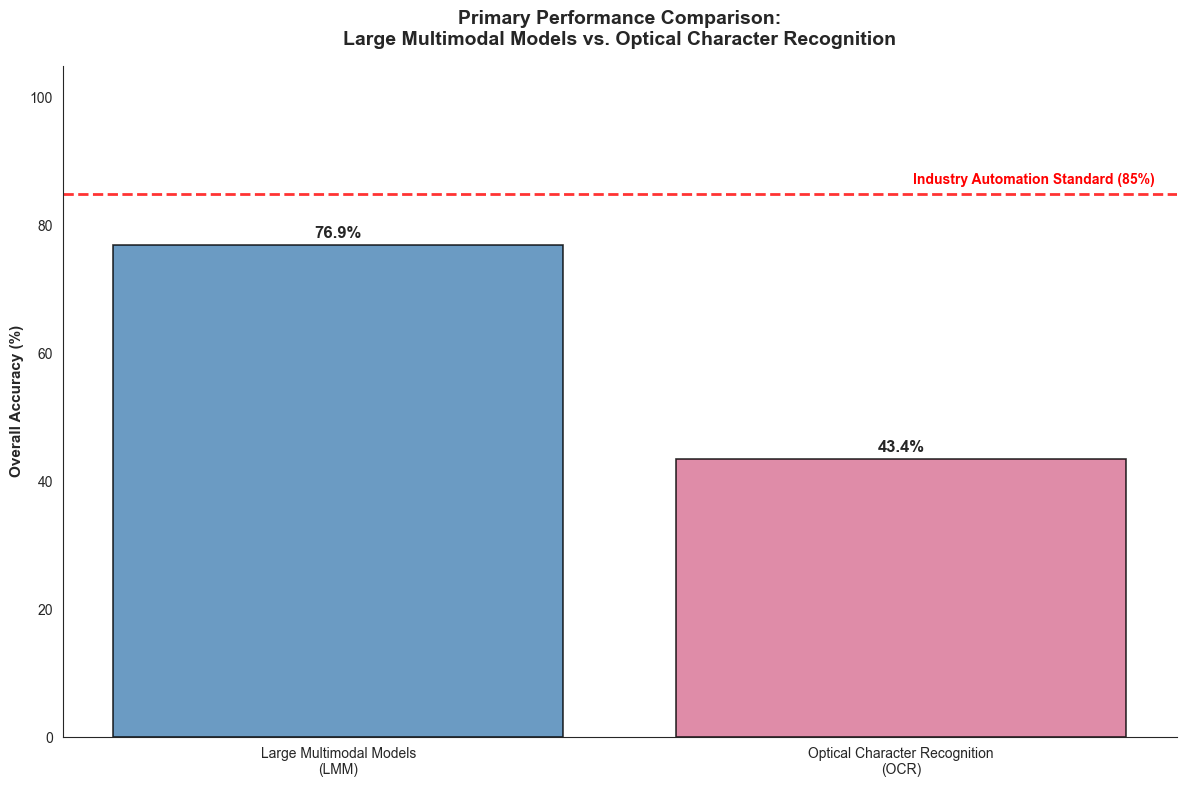


📋 Analysis Complete - Chart displayed above
📊 Data processed from: d:\UCSD_MJM\Deliverables-Code\analysis
🔍 LMM trials analyzed: 8
🔍 OCR trials analyzed: 7


In [5]:
## Primary Performance Comparison: LMM vs OCR

# Import visualization functions from our src module
from src.visualization import generate_primary_performance_analysis

# Generate the primary performance comparison chart and summary
fig, model_accuracies = generate_primary_performance_analysis(ANALYSIS_DIR)

# Display the chart
plt.show()

print(f"\n📋 Analysis Complete - Chart displayed above")
print(f"📊 Data processed from: {ANALYSIS_DIR}")
print(f"🔍 LMM trials analyzed: {len([f for f in ANALYSIS_DIR.glob('analysis-*') if 'pixtral' in f.name or 'llama' in f.name])}")
print(f"🔍 OCR trials analyzed: {len([f for f in ANALYSIS_DIR.glob('analysis-*') if 'doctr' in f.name])}")


### 1.2 Model Specific Comparisons

🔄 Creating comprehensive performance comparison grid...
   • Upper Left: LMM vs OCR (Overall Accuracy)
   • Upper Right: Pixtral vs Llama vs OCR (Overall Accuracy)
   • Lower Left: LMM vs OCR (Character Error Rate)
   • Lower Right: Pixtral vs Llama vs OCR (Character Error Rate)

🎨 Using standardized color scheme:
   • LMM/Pixtral: #20B2AA (Blue)
   • Llama: #4682B4 (Light Blue)
   • OCR: #D87093 (Purple)
   • Industry Standard: 85% threshold



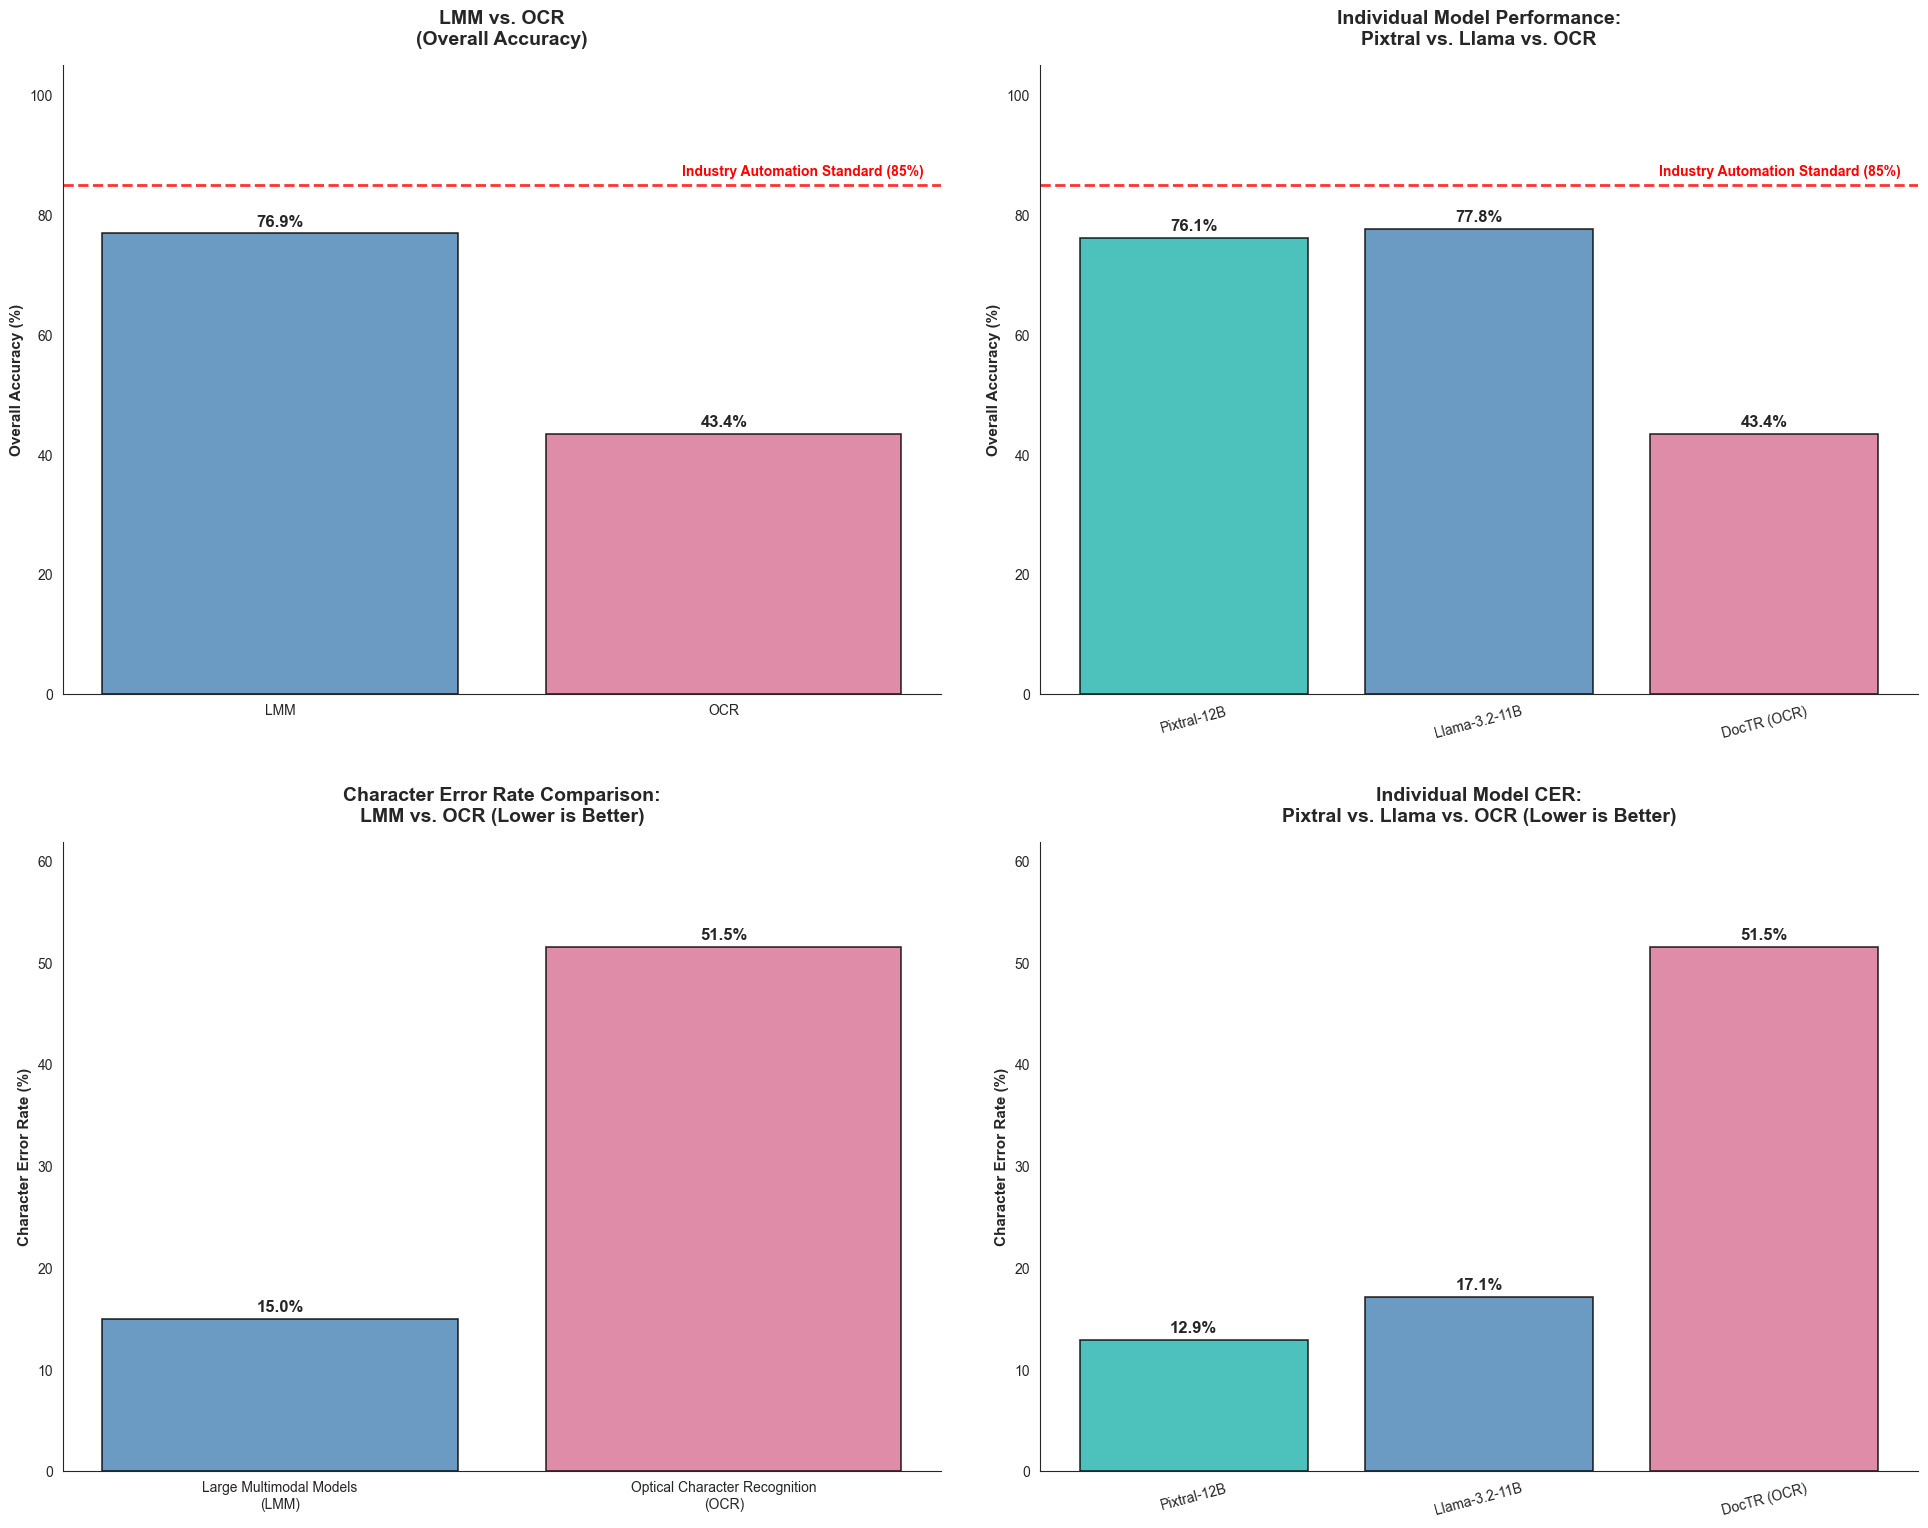


📊 COMPREHENSIVE PERFORMANCE GRID ANALYSIS

🎯 UPPER LEFT - LMM vs OCR (Accuracy):
   LMM: 76.9%  |  OCR: 43.4%  |  Gap: +33.5pp

🎯 UPPER RIGHT - Individual Models (Accuracy):
   Pixtral: 76.1%  |  Llama: 77.8%  |  OCR: 43.4%

🎯 LOWER LEFT - LMM vs OCR (Character Error Rate):
   LMM: 15.0%  |  OCR: 51.5%  |  LMM Advantage: -36.5pp

🎯 LOWER RIGHT - Individual Models (Character Error Rate):
   Pixtral: 12.9%  |  Llama: 17.1%  |  OCR: 51.5%

🏆 KEY INSIGHTS:
   • Best Overall Accuracy: Llama (77.8%)
   • Lowest Error Rate: Pixtral (12.9%)
   • Industry Standard (85%): ❌ LMMs Below | ❌ OCR Below


In [6]:
## Comprehensive Performance Comparison Grid

# Import the grid visualization function and styling from our src modules
from src.visualization import create_performance_comparison_grid
from src.styling import ANALYSIS_COLORS, INDUSTRY_STANDARDS

# Create the 2x2 grid of performance comparisons
print("🔄 Creating comprehensive performance comparison grid...")
print("   • Upper Left: LMM vs OCR (Overall Accuracy)")
print("   • Upper Right: Pixtral vs Llama vs OCR (Overall Accuracy)")
print("   • Lower Left: LMM vs OCR (Character Error Rate)")
print("   • Lower Right: Pixtral vs Llama vs OCR (Character Error Rate)")
print()
print(f"🎨 Using standardized color scheme:")
print(f"   • LMM/Pixtral: {ANALYSIS_COLORS['Pixtral']} (Blue)")
print(f"   • Llama: {ANALYSIS_COLORS['Llama']} (Light Blue)")
print(f"   • OCR: {ANALYSIS_COLORS['OCR']} (Purple)")
print(f"   • Industry Standard: {INDUSTRY_STANDARDS['automation_threshold']}% threshold")
print()

# Generate the grid visualization
grid_fig, all_performance_data = create_performance_comparison_grid(ANALYSIS_DIR)

# Display the grid
plt.show()

print("\n" + "="*80)
print("📊 COMPREHENSIVE PERFORMANCE GRID ANALYSIS")
print("="*80)

# Print summary statistics for each quadrant
print("\n🎯 UPPER LEFT - LMM vs OCR (Accuracy):")
lmm_acc = all_performance_data['lmm_vs_ocr_accuracy']['LMM']['overall_accuracy']
ocr_acc = all_performance_data['lmm_vs_ocr_accuracy']['OCR']['overall_accuracy']
print(f"   LMM: {lmm_acc:.1%}  |  OCR: {ocr_acc:.1%}  |  Gap: +{(lmm_acc-ocr_acc)*100:.1f}pp")

print("\n🎯 UPPER RIGHT - Individual Models (Accuracy):")
pix_acc = all_performance_data['individual_accuracy']['Pixtral']['overall_accuracy']
llama_acc = all_performance_data['individual_accuracy']['Llama']['overall_accuracy']
ocr_acc_ind = all_performance_data['individual_accuracy']['OCR']['overall_accuracy']
print(f"   Pixtral: {pix_acc:.1%}  |  Llama: {llama_acc:.1%}  |  OCR: {ocr_acc_ind:.1%}")

print("\n🎯 LOWER LEFT - LMM vs OCR (Character Error Rate):")
lmm_cer = all_performance_data['lmm_vs_ocr_cer']['LMM']['overall_cer']
ocr_cer = all_performance_data['lmm_vs_ocr_cer']['OCR']['overall_cer']
print(f"   LMM: {lmm_cer:.1%}  |  OCR: {ocr_cer:.1%}  |  LMM Advantage: -{(ocr_cer-lmm_cer)*100:.1f}pp")

print("\n🎯 LOWER RIGHT - Individual Models (Character Error Rate):")
pix_cer = all_performance_data['individual_cer']['Pixtral']['overall_cer']
llama_cer = all_performance_data['individual_cer']['Llama']['overall_cer']
ocr_cer_ind = all_performance_data['individual_cer']['OCR']['overall_cer']
print(f"   Pixtral: {pix_cer:.1%}  |  Llama: {llama_cer:.1%}  |  OCR: {ocr_cer_ind:.1%}")

print("\n🏆 KEY INSIGHTS:")
print(f"   • Best Overall Accuracy: {'Llama' if llama_acc > pix_acc else 'Pixtral'} ({max(llama_acc, pix_acc):.1%})")
print(f"   • Lowest Error Rate: {'Llama' if llama_cer < pix_cer else 'Pixtral'} ({min(llama_cer, pix_cer):.1%})")
industry_threshold = INDUSTRY_STANDARDS['automation_threshold'] / 100
print(f"   • Industry Standard ({INDUSTRY_STANDARDS['automation_threshold']}%): {'✅ LMMs Meet' if lmm_acc >= industry_threshold else '❌ LMMs Below'} | {'✅ OCR Meets' if ocr_acc >= industry_threshold else '❌ OCR Below'}")

print("="*80)


## Section 2: Prompt and Field Type Comparison
Four different prompt types wer compared across the both the pixtral and the llama LMMs.
### 2.1 Overall Prompt Analysis

🚀 PROMPT TYPE PERFORMANCE ANALYSIS
📊 Analyzing LMM performance across different prompt strategies...
🎯 Side-by-side comparison: Accuracy vs Character Error Rate

🚀 Generating Prompt Type Performance Analysis...

📈 DETAILED RESULTS BY PROMPT TYPE

🎯 ACCURACY PERFORMANCE (sorted highest to lowest):
   • Step By Step: 78.5% ❌ Below 85%
   • Basic Extraction: 78.0% ❌ Below 85%
   • Locational: 77.5% ❌ Below 85%
   • Detailed: 73.0% ❌ Below 85%

🎯 CHARACTER ERROR RATE PERFORMANCE (sorted lowest to highest):
   • Step By Step: 10.6% ⚠️ Needs Improvement (≥10%)
   • Locational: 14.3% ⚠️ Needs Improvement (≥10%)
   • Basic Extraction: 17.2% ⚠️ Needs Improvement (≥10%)
   • Detailed: 22.7% ⚠️ Needs Improvement (≥10%)

✅ Prompt Type Performance Analysis Complete
🎯 Accuracy data points analyzed: 4 prompt types
🎯 CER data points analyzed: 4 prompt types


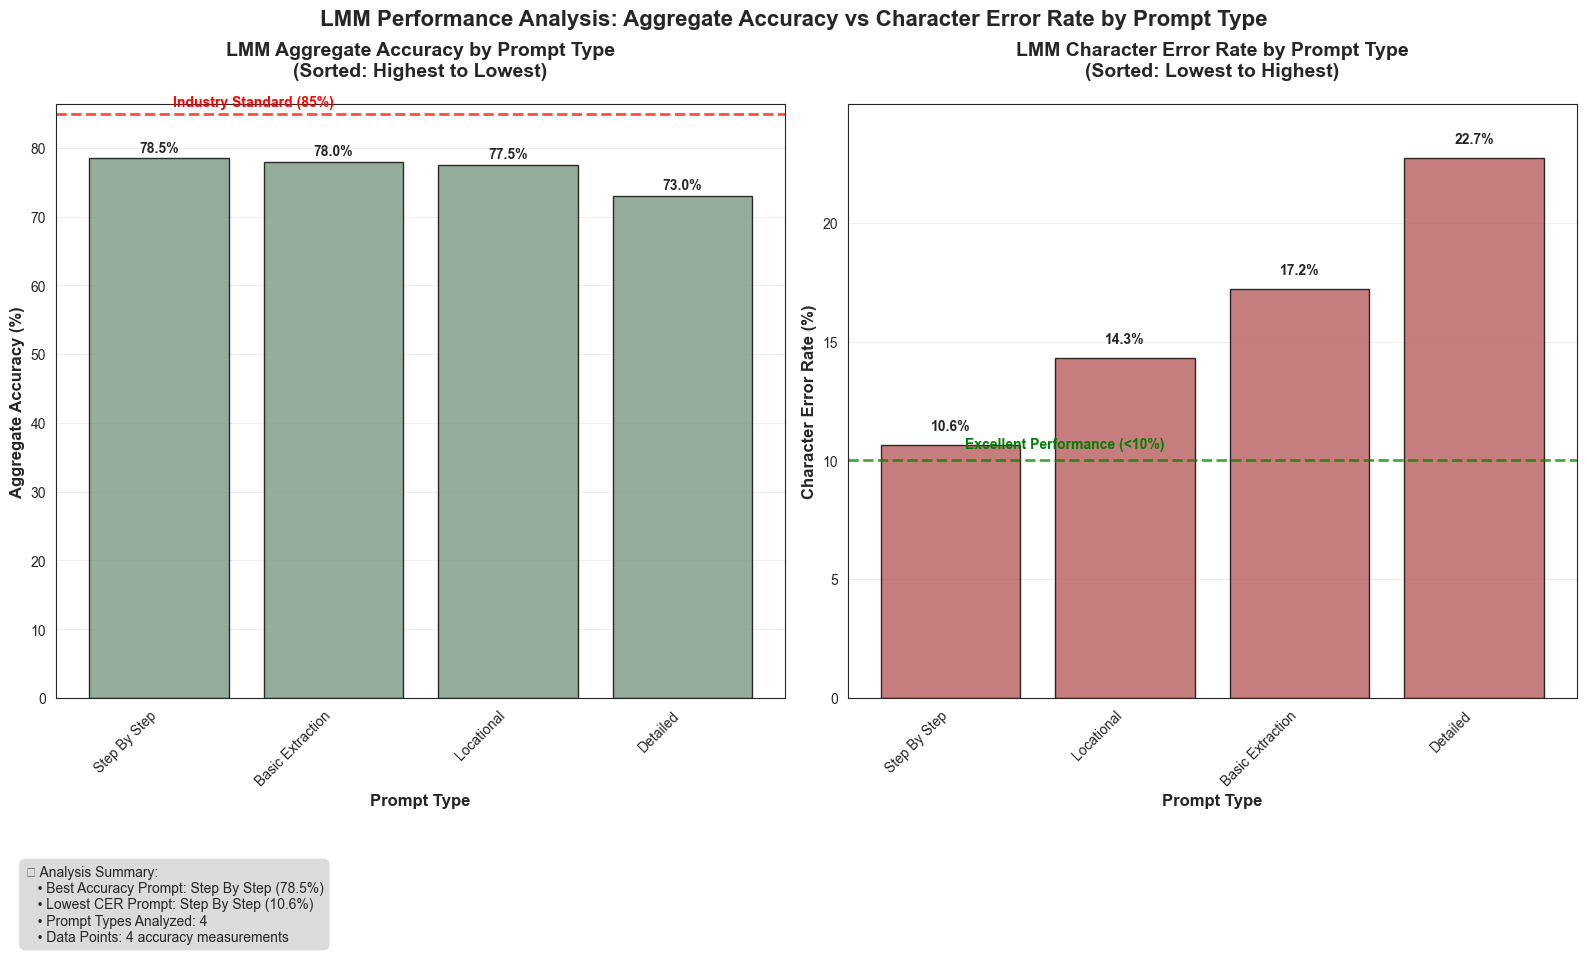


📋 Analysis Complete - Chart displayed above
📊 Data processed from comprehensive dataset
🔍 Prompt types analyzed: 4
🔍 Total experiments processed: 8

🏆 KEY FINDINGS:
   • Best Accuracy Prompt: Step By Step (78.5%)
   • Lowest CER Prompt: Step By Step (10.6%)
   • Prompt strategies tested: 4
   • ❌ No prompts meet 85% industry standard


In [7]:
## Section 2.1: Prompt Type Performance Analysis

# Import prompt performance analysis function from centralized visualization module
from src.visualization import generate_prompt_performance_analysis

# Generate the complete prompt type performance analysis
print("🚀 PROMPT TYPE PERFORMANCE ANALYSIS")
print("="*70)
print("📊 Analyzing LMM performance across different prompt strategies...")
print("🎯 Side-by-side comparison: Accuracy vs Character Error Rate")
print()

fig, accuracy_data, cer_data = generate_prompt_performance_analysis(COMPREHENSIVE_DATASET)

# Display the chart
plt.show()

print(f"\n📋 Analysis Complete - Chart displayed above")
print(f"📊 Data processed from comprehensive dataset")
print(f"🔍 Prompt types analyzed: {len(accuracy_data) if accuracy_data else 0}")

if accuracy_data:
    # Calculate total experiments safely
    try:
        total_experiments = 0
        for model_type in ['pixtral', 'llama']:
            if model_type in COMPREHENSIVE_DATASET['model_data']:
                experiments = COMPREHENSIVE_DATASET['model_data'][model_type]
                if hasattr(experiments, '__len__'):
                    total_experiments += len(experiments)
        print(f"🔍 Total experiments processed: {total_experiments}")
    except Exception as e:
        print(f"🔍 Total experiments processed: Unable to calculate ({str(e)})")
    
    print(f"\n🏆 KEY FINDINGS:")
    if accuracy_data:
        best_prompt = max(accuracy_data.items(), key=lambda x: x[1])
        print(f"   • Best Accuracy Prompt: {best_prompt[0].replace('_', ' ').title()} ({best_prompt[1]*100:.1f}%)")
    
    if cer_data:
        best_cer_prompt = min(cer_data.items(), key=lambda x: x[1])
        print(f"   • Lowest CER Prompt: {best_cer_prompt[0].replace('_', ' ').title()} ({best_cer_prompt[1]*100:.1f}%)")
    
    print(f"   • Prompt strategies tested: {len(accuracy_data)}")
    
    # Check if any prompts meet industry standards
    meets_standard = [p for p, acc in accuracy_data.items() if acc >= 0.85]
    if meets_standard:
        print(f"   • ✅ Prompts meeting 85% standard: {len(meets_standard)}")
    else:
        print(f"   • ❌ No prompts meet 85% industry standard")

print("="*70)


Most prompts performed equally well overall reaching close to 80%. The step-by-step prompt clearly outperformed the other prompt types in CER.

## Section 2.2: Field-Specific Analysis

In [8]:
# Updated visualization - reload to get simplified accuracy-only chart
import importlib
import src.visualization
importlib.reload(src.visualization)


<module 'src.visualization' from 'd:\\UCSD_MJM\\Deliverables-Code\\notebooks\\src\\visualization.py'>

🎯 FIELD-SPECIFIC PERFORMANCE ANALYSIS
📊 Comparing LMM performance across different extraction fields...
🔍 Work Order vs Total Cost: Side-by-side comparison
📈 Left Chart: Accuracy | Right Chart: Character Error Rate

🚀 Generating Field Type Performance Analysis...

📈 DETAILED RESULTS BY FIELD TYPE

🎯 ACCURACY PERFORMANCE:
   • Total Cost: 86.0% ✅ Above 85%
   • Work Order: 67.5% ❌ Below 85%

🔍 COMPARATIVE ANALYSIS:
   • Better Accuracy Field: Total Cost (+18.5pp advantage)
   • Work Order meets 85% standard: ❌ No
   • Total Cost meets 85% standard: ✅ Yes
   • ⚠️  Notable performance gap: 18.5 percentage points
   • 💡 Consider optimizing total cost extraction strategies

✅ Field Type Performance Analysis Complete
🎯 Field types analyzed: 2
📊 Focus: Accuracy comparison (CER analysis removed for clarity)


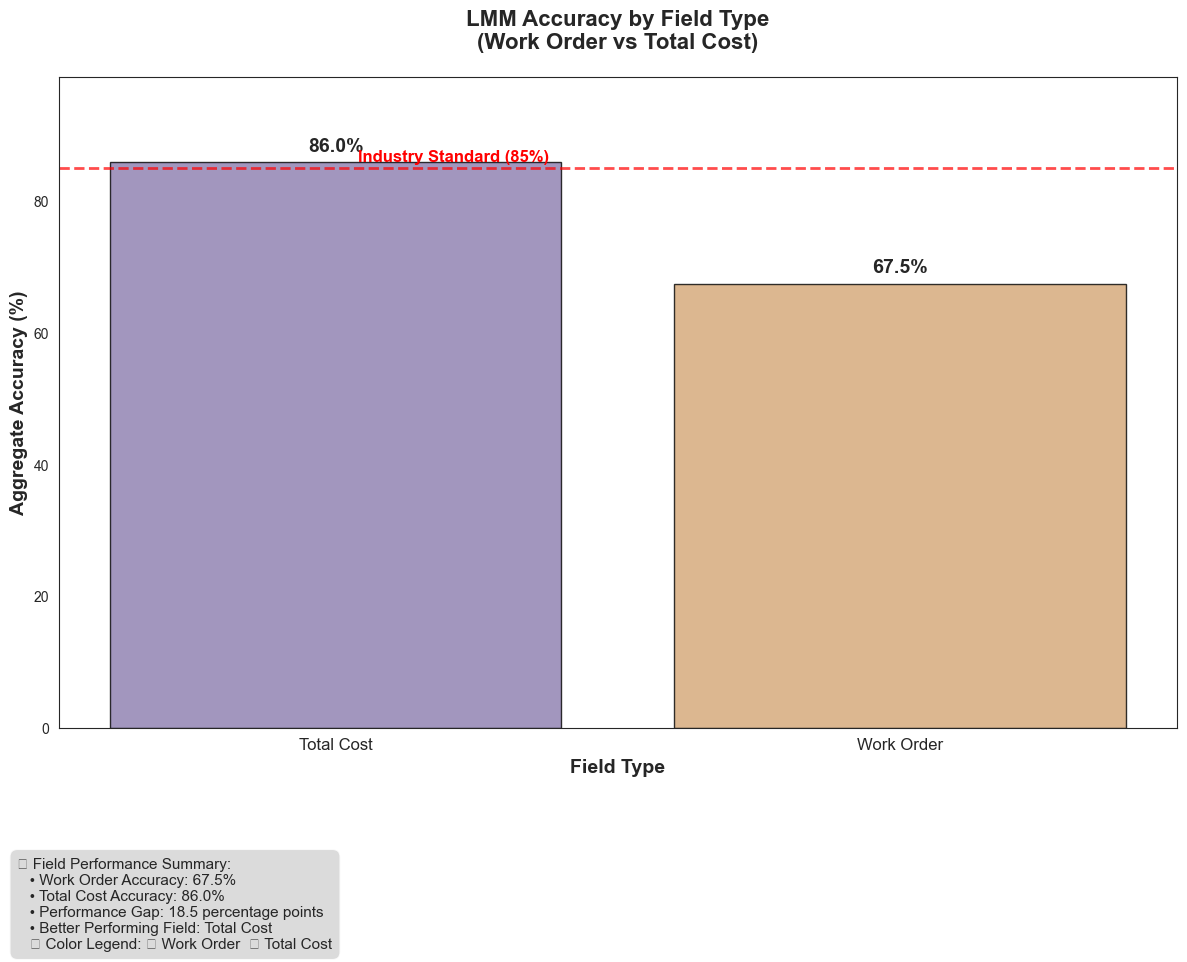


📋 Analysis Complete - Chart displayed above
📊 Data processed from comprehensive dataset
🔍 Field types analyzed: 2

🏆 FIELD COMPARISON INSIGHTS:
   • Work Order Accuracy: 67.5%
   • Total Cost Accuracy: 86.0%
   • Accuracy Gap: 18.5 percentage points
   • Work Order CER: 16.2%
   • Total Cost CER: 16.2%
   • CER Gap: 0.0 percentage points

📊 STRATEGIC INSIGHTS:
   • Better performing field (accuracy): Total Cost
   • Industry standard (85%): ✅ Met by at least one field
   • ⚠️  Significant performance gap detected (18.5pp)
   • 💡 Consider field-specific optimization strategies


In [9]:

# Import field performance analysis function from centralized visualization module
from src.visualization import generate_field_performance_analysis

# Generate the complete field type performance analysis
print("🎯 FIELD-SPECIFIC PERFORMANCE ANALYSIS")
print("="*70)
print("📊 Comparing LMM performance across different extraction fields...")
print("🔍 Work Order vs Total Cost: Side-by-side comparison")
print("📈 Left Chart: Accuracy | Right Chart: Character Error Rate")
print()

fig, accuracy_data, cer_data = generate_field_performance_analysis(COMPREHENSIVE_DATASET)

# Display the chart
plt.show()

print(f"\n📋 Analysis Complete - Chart displayed above")
print(f"📊 Data processed from comprehensive dataset")
print(f"🔍 Field types analyzed: {len(accuracy_data) if accuracy_data else 0}")

if accuracy_data and len(accuracy_data) == 2:
    # Calculate performance differences
    wo_acc = accuracy_data.get('work_order', 0) * 100
    tc_acc = accuracy_data.get('total_cost', 0) * 100
    acc_gap = abs(wo_acc - tc_acc)
    
    print(f"\n🏆 FIELD COMPARISON INSIGHTS:")
    print(f"   • Work Order Accuracy: {wo_acc:.1f}%")
    print(f"   • Total Cost Accuracy: {tc_acc:.1f}%")
    print(f"   • Accuracy Gap: {acc_gap:.1f} percentage points")
    
    if cer_data and len(cer_data) == 2:
        wo_cer = cer_data.get('work_order', 0) * 100
        tc_cer = cer_data.get('total_cost', 0) * 100
        cer_gap = abs(wo_cer - tc_cer)
        
        print(f"   • Work Order CER: {wo_cer:.1f}%")
        print(f"   • Total Cost CER: {tc_cer:.1f}%")
        print(f"   • CER Gap: {cer_gap:.1f} percentage points")
    
    # Overall field performance assessment
    better_accuracy = "Work Order" if wo_acc > tc_acc else "Total Cost"
    industry_standard_met = wo_acc >= 85 or tc_acc >= 85
    
    print(f"\n📊 STRATEGIC INSIGHTS:")
    print(f"   • Better performing field (accuracy): {better_accuracy}")
    print(f"   • Industry standard (85%): {'✅ Met by at least one field' if industry_standard_met else '❌ Not met by either field'}")
    
    if acc_gap > 10:
        print(f"   • ⚠️  Significant performance gap detected ({acc_gap:.1f}pp)")
        print(f"   • 💡 Consider field-specific optimization strategies")
    else:
        print(f"   • ✅ Relatively balanced field performance")

print("="*70)


It was much easier for the models to find the total cost and extract it successfully than the work order number.

## 3. Model, Prompt, and Field Type - Detailed Variable Analysis

### 3.1 LMM Models vs Prompts

🔍 Creating LMM Models vs Prompts Accuracy Heatmap...

📊 HEATMAP ANALYSIS SUMMARY:
   • Models analyzed: 2
   • Prompt types: 4
   • Best combination: Llama + step_by_step (84.0%)


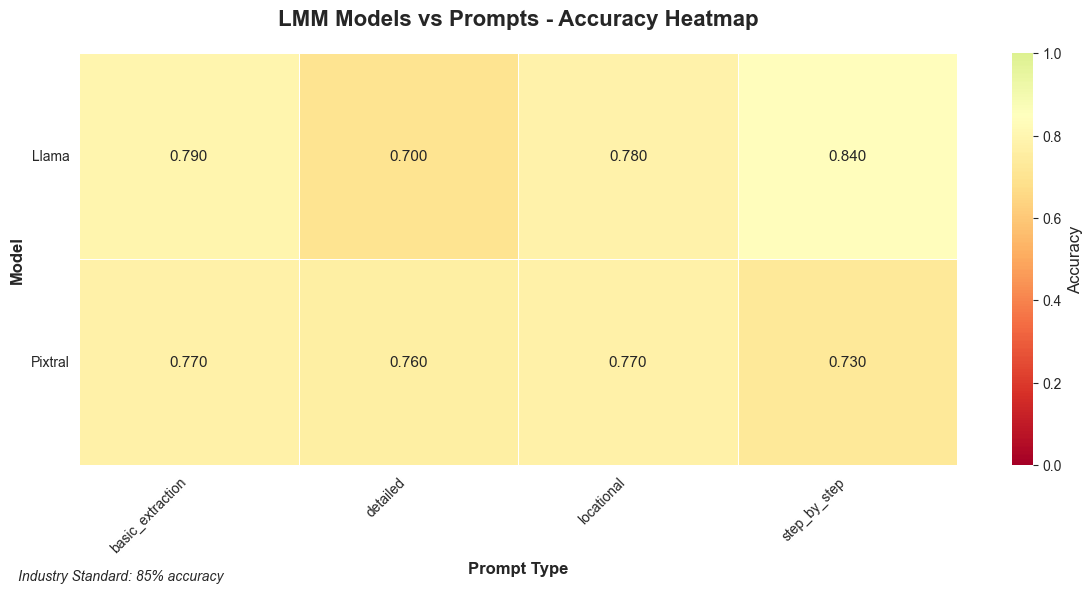

In [10]:
# LMM Models vs Prompts - Accuracy Heatmap
import importlib
importlib.reload(src.visualization)

fig, heatmap_data = src.visualization.generate_lmm_models_prompts_accuracy_heatmap(COMPREHENSIVE_DATASET)
plt.show()


🔍 Creating LMM Models vs Prompts CER Heatmap...

📊 CER HEATMAP ANALYSIS SUMMARY:
   • Models analyzed: 2
   • Prompt types: 4
   • Best combination (lowest CER): Pixtral + step_by_step (7.1%)


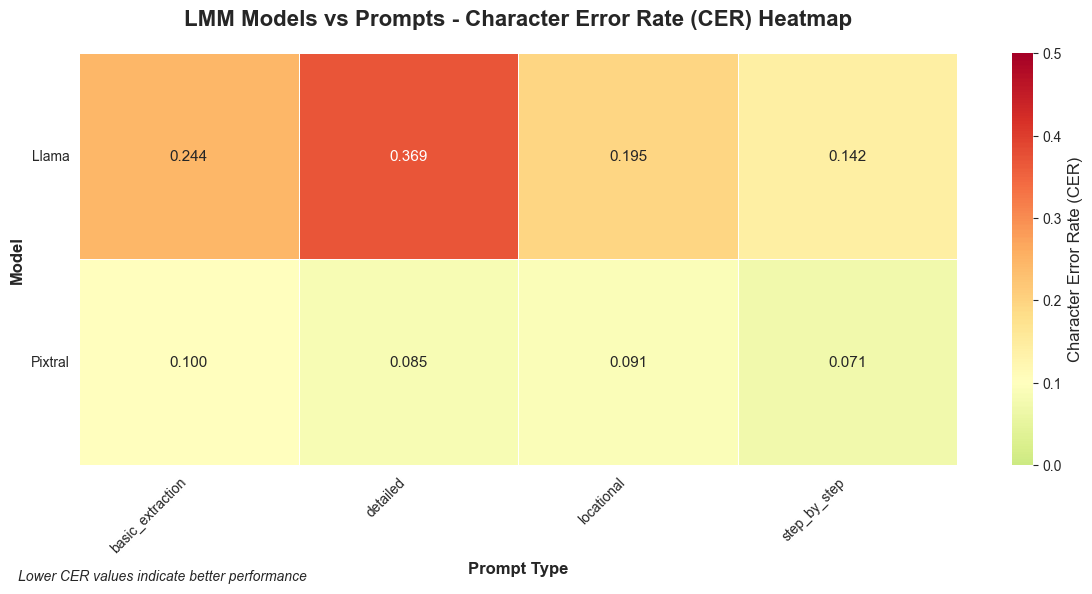

In [11]:
# LMM Models vs Prompts - CER Heatmap
fig, cer_heatmap_data = src.visualization.generate_lmm_models_prompts_cer_heatmap(COMPREHENSIVE_DATASET)
plt.show()


MODELS VS. PROMPTS
Llama Step-by-Step is the best Model-Prompt combination based on Accuracy, Pixtral Step-by-Step is the best based on CER

### 3.2 LMM Query Types vs Prompts

Cross-analysis of how different prompt types perform on specific query types (Work Order vs Total Cost extraction).


🔍 Creating LMM Query Types vs Prompts Accuracy Heatmap...

📊 QUERY-PROMPT HEATMAP ANALYSIS:
   • Prompt types analyzed: 4
   • Query types: Work Order, Total Cost
   • Average Work Order accuracy: 67.5%
   • Average Total Cost accuracy: 86.0%


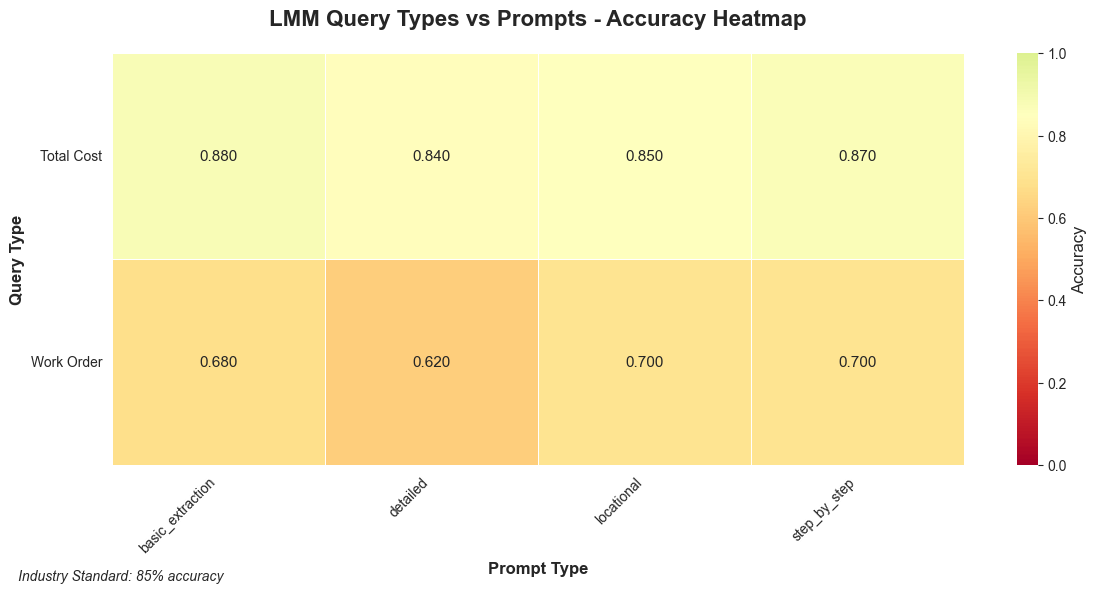

In [12]:
# LMM Query Types vs Prompts - Accuracy Heatmap
fig, query_heatmap_data = src.visualization.generate_lmm_query_prompts_accuracy_heatmap(COMPREHENSIVE_DATASET)
plt.show()


🔍 Creating LMM Query Types vs Prompts CER Heatmap...

📊 QUERY-PROMPT CER HEATMAP ANALYSIS:
   • Prompt types analyzed: 4
   • Query types: Work Order, Total Cost
   • Average Work Order CER: 16.2%
   • Average Total Cost CER: 16.2%


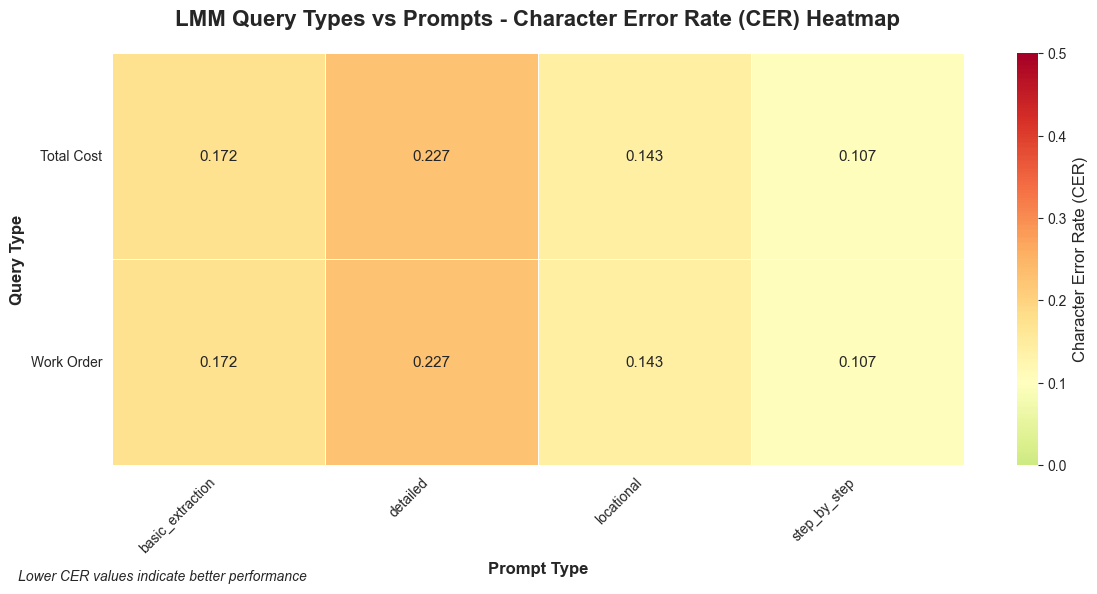

In [13]:
# LMM Query Types vs Prompts - CER Heatmap
fig, query_cer_data = src.visualization.generate_lmm_query_prompts_cer_heatmap(COMPREHENSIVE_DATASET)
plt.show()


Easier to get total cost than work order number.  Step-by-step prompting continues to show an advantage across querry types.

### 3.3  Comprehensive Model-Prompt Combination vs Accuracy 

Comprehensive comparison of all model configurations (LMM + OCR) across query types. Models are sorted by average performance for easy identification of best performers.
CER was only calculated on the Work Order Field while accuracy on a true false scale was computed for both fields in each model-prompt combo and each choice of recognition model when running the OCR tests

🔍 Creating All Models vs Query Types Accuracy Heatmap...

📊 ALL MODELS HEATMAP ANALYSIS:
   • Total model configurations: 15
   • Query types: Work Order, Total Cost
   • Overall average accuracy: 61.2%
   • Best performing model: Llama-step_by_step


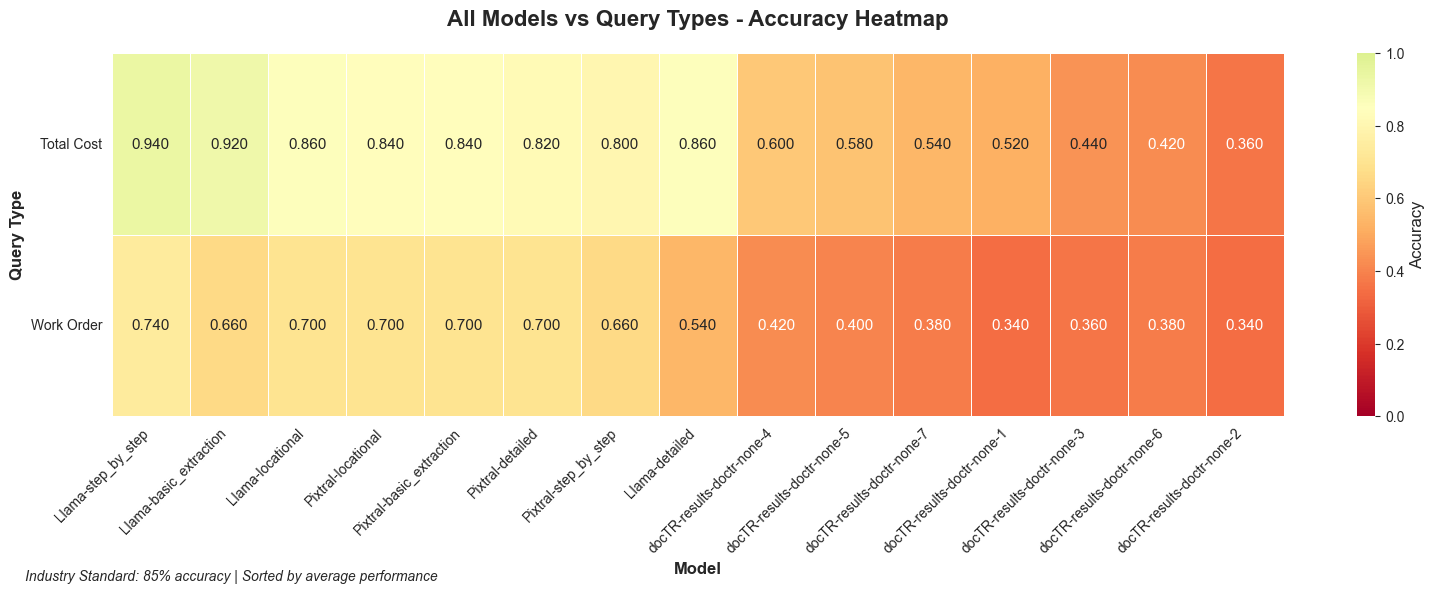

In [14]:
# All Models vs Query Types - Accuracy Heatmap
fig, all_models_data = src.visualization.generate_all_models_query_heatmap(COMPREHENSIVE_DATASET)
plt.show()


On a pure accuracy standpoint Llama Step-by-step is the clear winner.

## 4. Model Consistency Study
Analysis of model consistency and performance variability. Lower ranges indicate more consistent performance across different experiments.
Intended to look at spread of results between models.  How reliable are the results we are getting from each model. Can we expect similar results at scale?


### 4.1 Consistency over Accuracy

🔍 Calculating Model Performance Ranges...

📊 PERFORMANCE RANGE ANALYSIS:
   • Models analyzed: 3
   • Most consistent: Pixtral (range: 0.040)
   • Least consistent: Doctr (range: 0.160)
   • Average performance across models: 65.6%
   • Models meeting industry standard (≥85%): 0/3


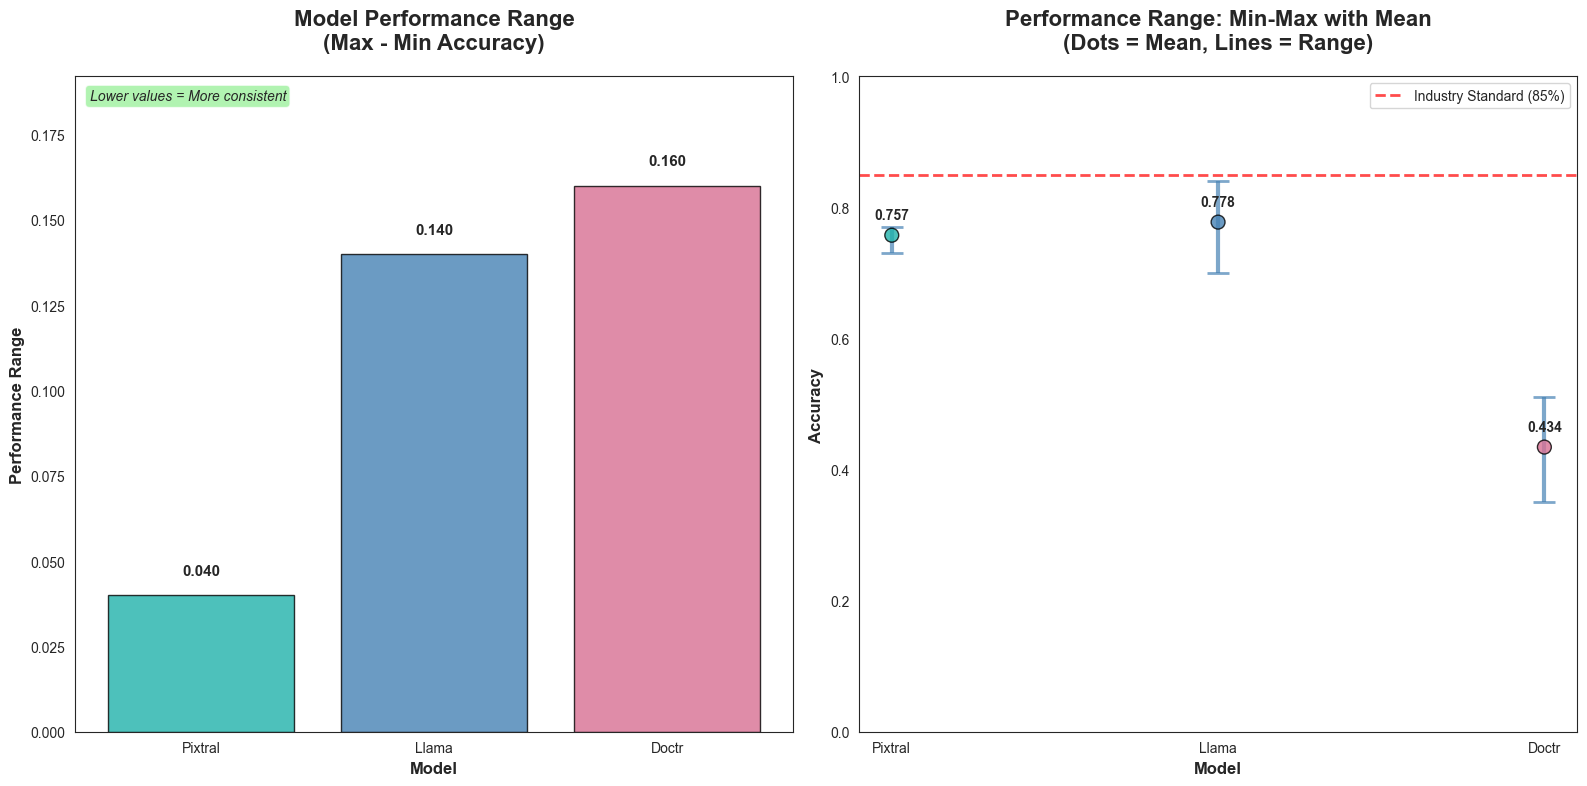

In [15]:
# Model Performance Range Analysis - Accuracy
import importlib
importlib.reload(src.visualization)

fig, performance_stats = src.visualization.generate_model_performance_range_analysis(COMPREHENSIVE_DATASET)
plt.show()


Llama has a higher max accuracy than Pixtral but Pixtral is more consistent.  It has a smaller range of results well clustered around its mean accuracy. 

### 4.2 Consistency over Character Error Rate (CER)

CER consistency analysis across model types. Lower ranges indicate more predictable character-level error rates.


🔍 Calculating Model CER Ranges...

📊 CER RANGE ANALYSIS:
   • Models analyzed: 3
   • Most consistent: Pixtral (CER range: 0.030)
   • Least consistent: Llama (CER range: 0.228)
   • Average CER across models: 28.3%
   • Best performing model (lowest CER): Pixtral (8.7%)


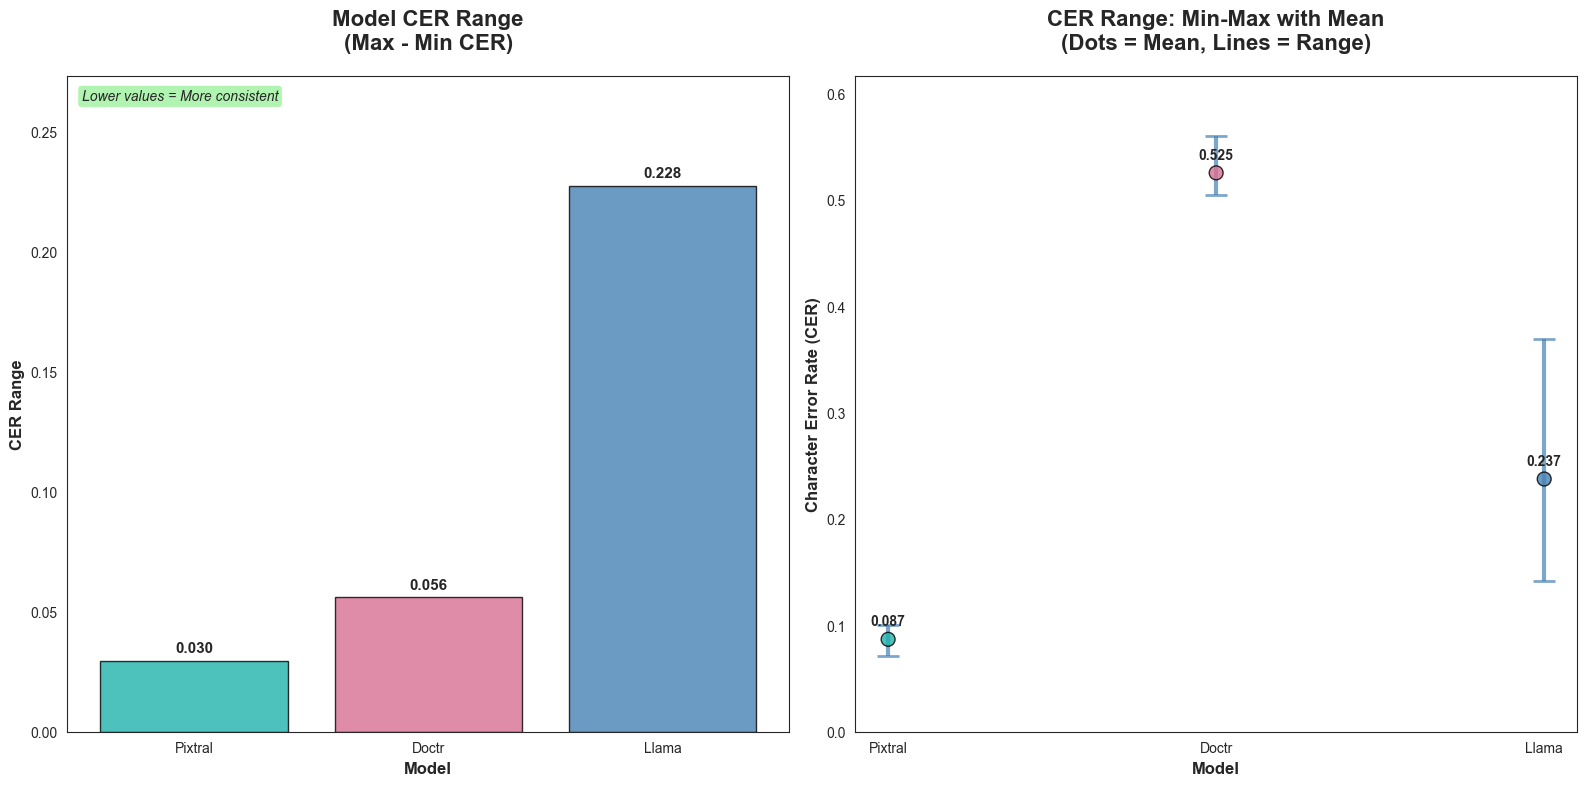

In [16]:
# Model Performance Range Analysis - CER
fig, cer_stats = src.visualization.generate_model_cer_range_analysis(COMPREHENSIVE_DATASET)
plt.show()


Llama actually performs the worst in terms of CER spread.

## 4.3. Range vs Accuracy and CER Scatter

Look at the tradeoff between range and accuracy. 

Side-by-side analysis of performance gaps between Total Cost and Work Order extraction across different performance metrics. Positive gaps indicate Total Cost is easier to extract, negative gaps indicate Work Order is easier.


🔍 Creating Performance Gap Scatter Analysis...

📊 PERFORMANCE GAP ANALYSIS:
   • Model configurations analyzed: 15
   • Average gap (TC - WO): 0.155
   • Models where TC is easier: 15/15
   • Models where WO is easier: 0/15
   • Largest TC advantage: Llama-detailed (0.320)
   • Largest WO advantage: docTR-results-doctr-none-2 (0.020)
   • Accuracy-CER correlation: -0.922

📝 NOTE: Both charts now flow from worst (lower-left) to best (upper-right):
         Left: Low accuracy + high gap → High accuracy + low gap
         Right: High CER + high gap → Low CER + low gap
         Lower gaps are better (smaller performance difference between TC and WO extraction).


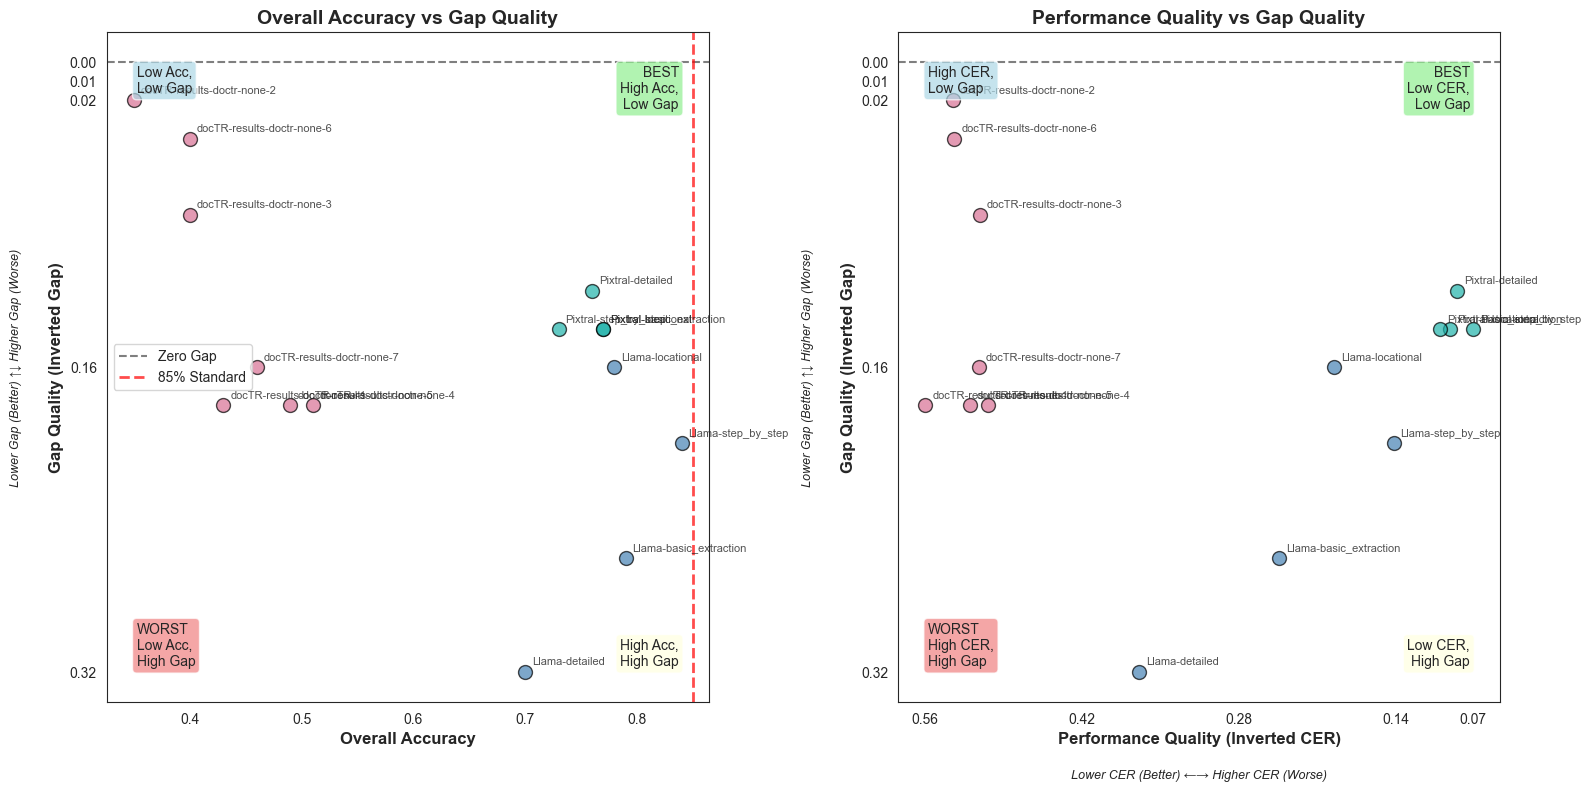

In [17]:
# Performance Gap Scatter Analysis
import importlib
importlib.reload(src.visualization)

fig, gap_data = src.visualization.generate_performance_gap_scatter_analysis(COMPREHENSIVE_DATASET)
plt.show()


Llama step-by-step still holds the lead in terms of accuracy performance but the cluster of pixtral models shows comparable performance with lower spread. Pixtral-detailed and pixtral step-by-step show good performance promise

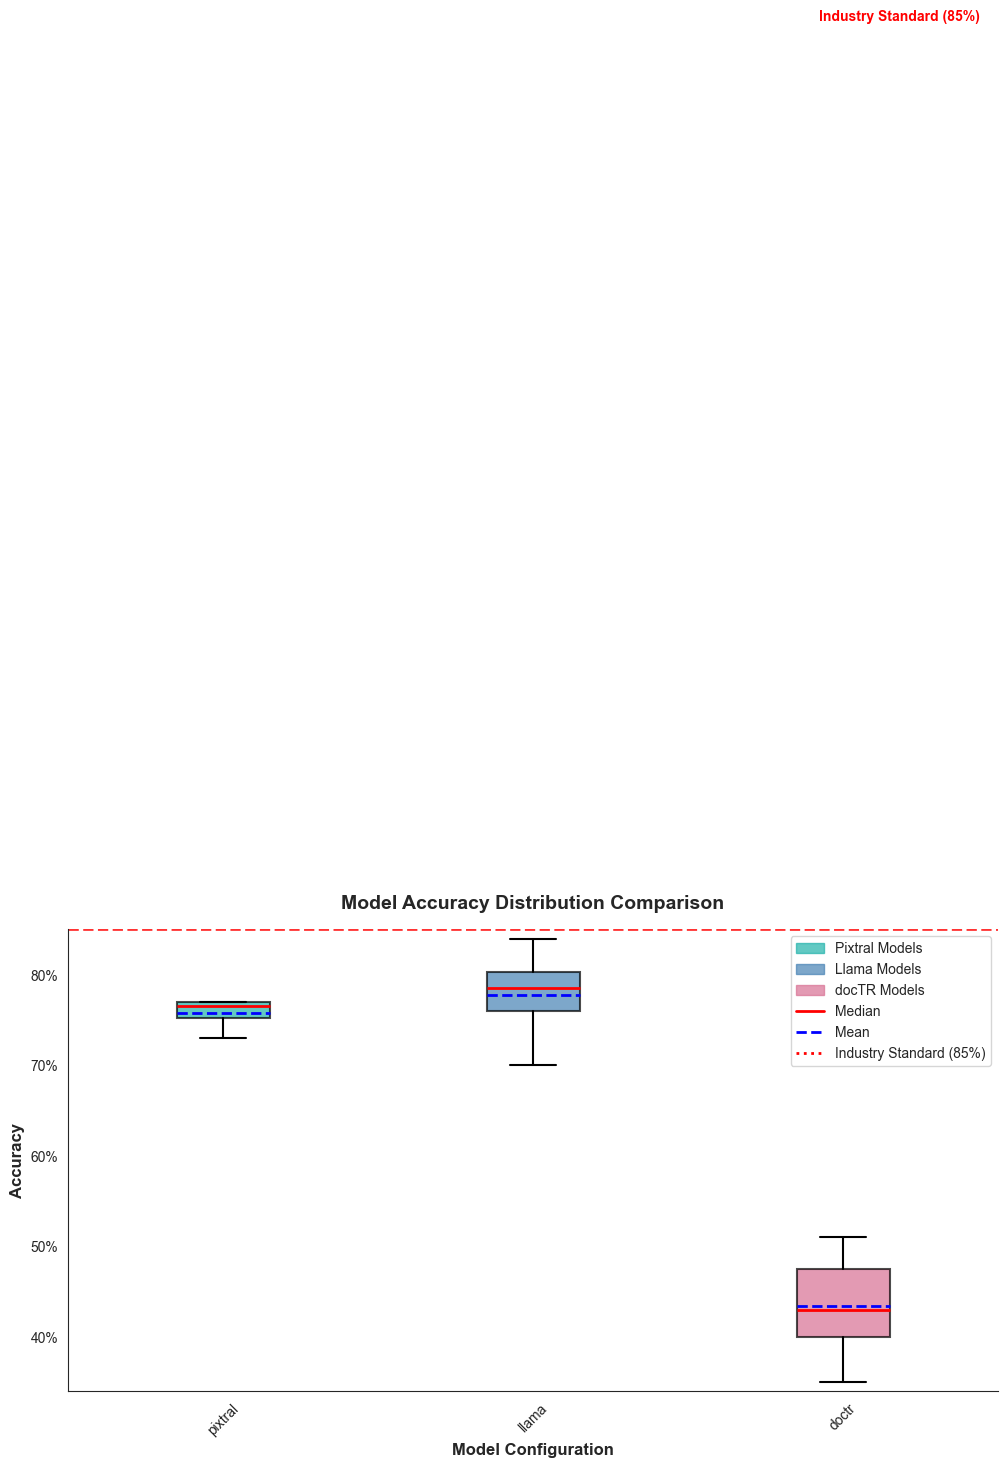


📈 ACCURACY BOX PLOT INSIGHTS:
🔍 DATASET OVERVIEW:
   • Total model configurations: 3
   • Total accuracy measurements: 15
   • Overall median accuracy: 70.0%
   • Overall mean accuracy: 61.2% (±17.2%)

📊 PERFORMANCE DISTRIBUTION:
   • Excellent (≥90%):   0 measurements (  0.0%)
   • Good (85-90%):   0 measurements (  0.0%)
   • Fair (70-85%):   8 measurements ( 53.3%)
   • Poor (<70%):   7 measurements ( 46.7%)

🤖 MODEL TYPE BREAKDOWN:
   • Pixtral configurations: 0
   • Llama configurations: 0
   • docTR configurations: 0

🏆 PERFORMANCE EXTREMES:
   • Best performer: llama (median accuracy: 78.5%)
   • Worst performer: doctr (median accuracy: 43.0%)
   • Performance gap: 35.5%

🎯 INDUSTRY BENCHMARK ANALYSIS:
   • Models meeting industry threshold (≥85%): 0/3 (0.0%)
   • No models currently meet the industry threshold
   • Closest to threshold: llama (accuracy: 78.5%)

📦 BOX PLOT DISTRIBUTION INSIGHTS:
   • pixtral:
     - Median: 76.5%
     - IQR: 1.8% (Q1: 75.2%, Q3: 77.0%)
     - R

In [18]:
# Reload visualization module to get new functions
import importlib
importlib.reload(src.visualization)
from src.visualization import generate_model_accuracy_boxplot_analysis

# Generate accuracy box plot comparison
fig, accuracy_data = generate_model_accuracy_boxplot_analysis(COMPREHENSIVE_DATASET)
plt.show()

# Summary statistics
print("\n" + "="*80)
print("📈 ACCURACY BOX PLOT INSIGHTS:")
print("="*80)

if accuracy_data:
    # Calculate overall statistics
    all_accuracy_values = []
    model_count = len(accuracy_data)
    
    for model, values in accuracy_data.items():
        all_accuracy_values.extend(values)
    
    if all_accuracy_values:
        overall_median = np.median(all_accuracy_values)
        overall_mean = np.mean(all_accuracy_values)
        overall_std = np.std(all_accuracy_values)
        
        print(f"🔍 DATASET OVERVIEW:")
        print(f"   • Total model configurations: {model_count}")
        print(f"   • Total accuracy measurements: {len(all_accuracy_values)}")
        print(f"   • Overall median accuracy: {overall_median:.1%}")
        print(f"   • Overall mean accuracy: {overall_mean:.1%} (±{overall_std:.1%})")
        
        # Performance tier analysis
        excellent_count = sum(1 for x in all_accuracy_values if x >= 0.9)
        good_count = sum(1 for x in all_accuracy_values if 0.85 <= x < 0.9)
        fair_count = sum(1 for x in all_accuracy_values if 0.7 <= x < 0.85)
        poor_count = sum(1 for x in all_accuracy_values if x < 0.7)
        
        total_measurements = len(all_accuracy_values)
        
        print(f"\n📊 PERFORMANCE DISTRIBUTION:")
        print(f"   • Excellent (≥90%): {excellent_count:3d} measurements ({100*excellent_count/total_measurements:5.1f}%)")
        print(f"   • Good (85-90%): {good_count:3d} measurements ({100*good_count/total_measurements:5.1f}%)")
        print(f"   • Fair (70-85%): {fair_count:3d} measurements ({100*fair_count/total_measurements:5.1f}%)")
        print(f"   • Poor (<70%): {poor_count:3d} measurements ({100*poor_count/total_measurements:5.1f}%)")
        
        # Model type breakdown
        pixtral_models = [m for m in accuracy_data.keys() if m.startswith('Pixtral')]
        llama_models = [m for m in accuracy_data.keys() if m.startswith('Llama')]
        doctr_models = [m for m in accuracy_data.keys() if m.startswith('docTR')]
        
        print(f"\n🤖 MODEL TYPE BREAKDOWN:")
        print(f"   • Pixtral configurations: {len(pixtral_models)}")
        print(f"   • Llama configurations: {len(llama_models)}")
        print(f"   • docTR configurations: {len(doctr_models)}")
        
        # Best and worst performers
        model_medians = {model: np.median(values) for model, values in accuracy_data.items()}
        best_model = max(model_medians.items(), key=lambda x: x[1])
        worst_model = min(model_medians.items(), key=lambda x: x[1])
        
        print(f"\n🏆 PERFORMANCE EXTREMES:")
        print(f"   • Best performer: {best_model[0]} (median accuracy: {best_model[1]:.1%})")
        print(f"   • Worst performer: {worst_model[0]} (median accuracy: {worst_model[1]:.1%})")
        print(f"   • Performance gap: {best_model[1] - worst_model[1]:.1%}")
        
        # Industry benchmark comparison
        industry_threshold = 0.85  # Good threshold
        models_meeting_threshold = sum(1 for median in model_medians.values() if median >= industry_threshold)
        
        print(f"\n🎯 INDUSTRY BENCHMARK ANALYSIS:")
        print(f"   • Models meeting industry threshold (≥{industry_threshold:.0%}): {models_meeting_threshold}/{model_count} ({100*models_meeting_threshold/model_count:.1f}%)")
        
        if models_meeting_threshold > 0:
            print(f"   • These models are suitable for production deployment")
        else:
            print(f"   • No models currently meet the industry threshold")
            # Find closest to threshold
            closest_model = max(model_medians.items(), key=lambda x: x[1])
            print(f"   • Closest to threshold: {closest_model[0]} (accuracy: {closest_model[1]:.1%})")
        
        # Box plot specific insights
        print(f"\n📦 BOX PLOT DISTRIBUTION INSIGHTS:")
        for model, values in accuracy_data.items():
            if len(values) > 1:
                q1 = np.percentile(values, 25)
                q3 = np.percentile(values, 75)
                iqr = q3 - q1
                range_val = max(values) - min(values)
                
                print(f"   • {model}:")
                print(f"     - Median: {np.median(values):.1%}")
                print(f"     - IQR: {iqr:.1%} (Q1: {q1:.1%}, Q3: {q3:.1%})")
                print(f"     - Range: {range_val:.1%}")
                print(f"     - Consistency: {'High' if iqr < 0.1 else 'Moderate' if iqr < 0.2 else 'Low'}")

print("\n" + "="*80)

## 6. Compute Resource (Timed) Comparison
Look at the tradeoff between speed and accuracy

🚀 Starting efficiency frontier analysis...
🔍 Processing 3 model types...
   • Found model: pixtral
   • Found model: llama
   • Found model: doctr
   ✓ Loaded processing times from results-pixtral-bfloat16-3.json: avg 1.53s
   • Pixtral-locational: 77.0% accuracy, 1.53s processing time
   ✓ Loaded processing times from results-pixtral-bfloat16-2.json: avg 1.62s
   • Pixtral-detailed: 76.0% accuracy, 1.62s processing time
   ✓ Loaded processing times from results-pixtral-bfloat16-1.json: avg 1.54s
   • Pixtral-basic_extraction: 77.0% accuracy, 1.54s processing time
   ✓ Loaded processing times from results-pixtral-bfloat16-4.json: avg 1.81s
   • Pixtral-step_by_step: 73.0% accuracy, 1.81s processing time
   ✓ Loaded processing times from results-llama-torch_dtype-4.json: avg 5.82s
   • Llama-step_by_step: 84.0% accuracy, 5.82s processing time
   ✓ Loaded processing times from results-llama-torch_dtype-1.json: avg 5.74s
   • Llama-basic_extraction: 79.0% accuracy, 5.74s processing time
 

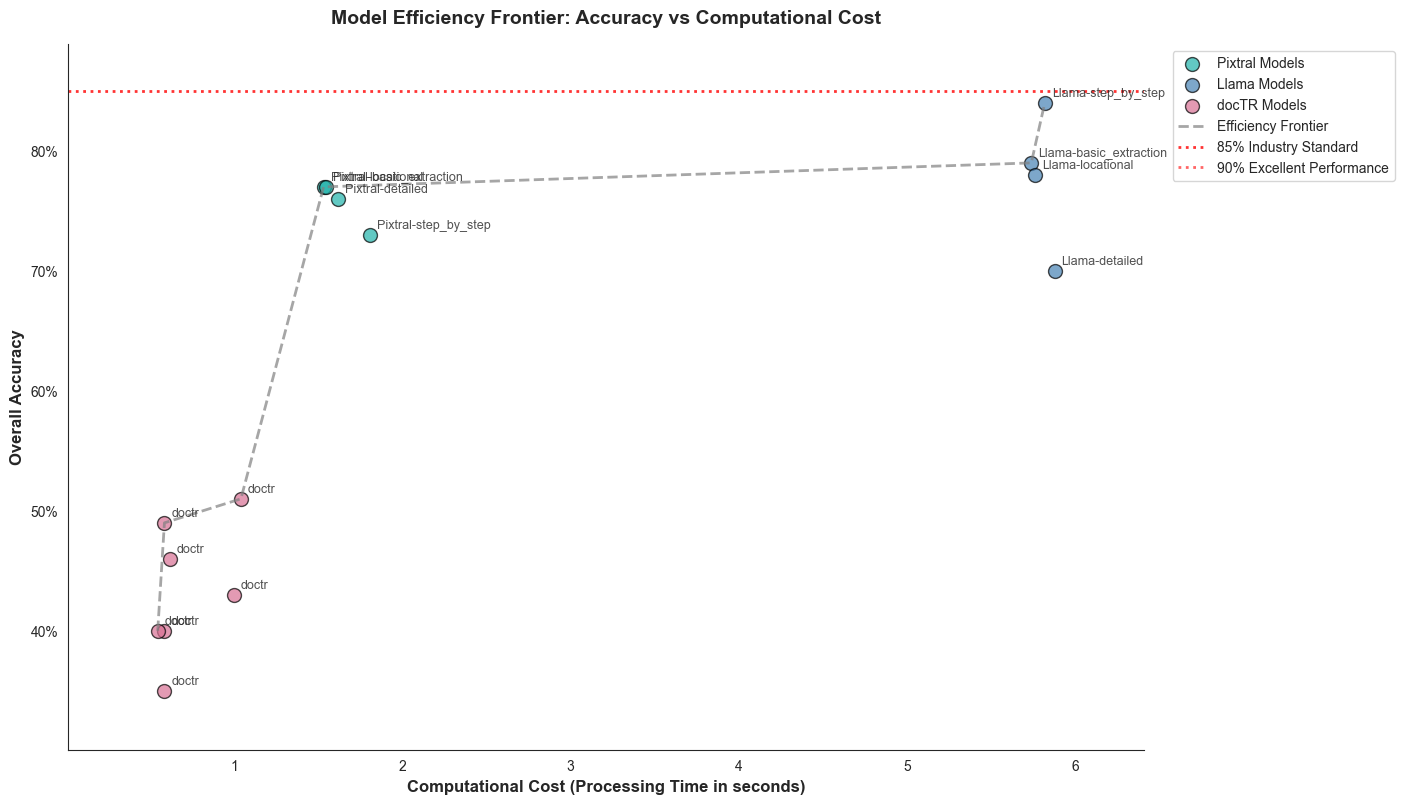


📈 MODEL EFFICIENCY FRONTIER ANALYSIS:
🔍 DATASET OVERVIEW:
   • Total model configurations: 15
   • Accuracy range: 35.0% - 84.0%
   • Processing time range: 0.54s - 5.88s

⚠️  NOTE: Processing times may be estimated based on typical model performance
   if actual timing data was not available in the dataset.

🤖 MODEL TYPE BREAKDOWN:
   • Pixtral configurations: 4
   • Llama configurations: 4
   • docTR configurations: 7

⚡ PERFORMANCE VS SPEED ANALYSIS:
   • Fastest model: doctr (0.54s, 40.0% accuracy)
   • Slowest model: Llama-detailed (5.88s, 70.0% accuracy)
   • Speed difference: 10.8x
   • Most accurate: Llama-step_by_step (84.0% accuracy, 5.82s)
   • Least accurate: doctr (35.0% accuracy, 0.58s)

🎯 EFFICIENCY ANALYSIS (Accuracy per Second):
   • Most efficient: doctr (0.840 accuracy/sec)
   • Least efficient: Llama-detailed (0.119 accuracy/sec)
   • Efficiency ratio: 7.1x

📊 INDUSTRY STANDARD ANALYSIS (≥85%):
   • Models meeting standard: 0/15 (0.0%)

🔬 MODEL TYPE PERFORMANCE:
  

In [19]:
# Reload visualization module to get new functions
import importlib
import numpy as np  # Make sure numpy is imported for the random processing times
importlib.reload(src.visualization)
from src.visualization import generate_efficiency_frontier_analysis

# Generate efficiency frontier analysis
print("🚀 Starting efficiency frontier analysis...")
fig, efficiency_data = generate_efficiency_frontier_analysis(COMPREHENSIVE_DATASET)
plt.show()

# Summary statistics
print("\n" + "="*80)
print("📈 MODEL EFFICIENCY FRONTIER ANALYSIS:")
print("="*80)

if efficiency_data:
    # Calculate overall statistics
    model_count = len(efficiency_data)
    accuracies = [d['accuracy'] for d in efficiency_data]
    processing_times = [d['processing_time'] for d in efficiency_data]
    
    print(f"🔍 DATASET OVERVIEW:")
    print(f"   • Total model configurations: {model_count}")
    print(f"   • Accuracy range: {min(accuracies):.1%} - {max(accuracies):.1%}")
    print(f"   • Processing time range: {min(processing_times):.2f}s - {max(processing_times):.2f}s")
    
    # Check if we're using estimated times
    print(f"\n⚠️  NOTE: Processing times may be estimated based on typical model performance")
    print(f"   if actual timing data was not available in the dataset.")
    
    # Model type breakdown
    pixtral_models = [d for d in efficiency_data if d['model_type'] == 'Pixtral']
    llama_models = [d for d in efficiency_data if d['model_type'] == 'Llama']
    doctr_models = [d for d in efficiency_data if d['model_type'] == 'docTR']
    
    print(f"\n🤖 MODEL TYPE BREAKDOWN:")
    print(f"   • Pixtral configurations: {len(pixtral_models)}")
    print(f"   • Llama configurations: {len(llama_models)}")
    print(f"   • docTR configurations: {len(doctr_models)}")
    
    # Performance vs speed analysis
    print(f"\n⚡ PERFORMANCE VS SPEED ANALYSIS:")
    
    # Find fastest and slowest models
    fastest_model = min(efficiency_data, key=lambda x: x['processing_time'])
    slowest_model = max(efficiency_data, key=lambda x: x['processing_time'])
    
    print(f"   • Fastest model: {fastest_model['model_label']} ({fastest_model['processing_time']:.2f}s, {fastest_model['accuracy']:.1%} accuracy)")
    print(f"   • Slowest model: {slowest_model['model_label']} ({slowest_model['processing_time']:.2f}s, {slowest_model['accuracy']:.1%} accuracy)")
    print(f"   • Speed difference: {slowest_model['processing_time'] / fastest_model['processing_time']:.1f}x")
    
    # Find most and least accurate models
    most_accurate = max(efficiency_data, key=lambda x: x['accuracy'])
    least_accurate = min(efficiency_data, key=lambda x: x['accuracy'])
    
    print(f"   • Most accurate: {most_accurate['model_label']} ({most_accurate['accuracy']:.1%} accuracy, {most_accurate['processing_time']:.2f}s)")
    print(f"   • Least accurate: {least_accurate['model_label']} ({least_accurate['accuracy']:.1%} accuracy, {least_accurate['processing_time']:.2f}s)")
    
    # Efficiency analysis (accuracy per second)
    for model in efficiency_data:
        model['efficiency'] = model['accuracy'] / model['processing_time']
    
    most_efficient = max(efficiency_data, key=lambda x: x['efficiency'])
    least_efficient = min(efficiency_data, key=lambda x: x['efficiency'])
    
    print(f"\n🎯 EFFICIENCY ANALYSIS (Accuracy per Second):")
    print(f"   • Most efficient: {most_efficient['model_label']} ({most_efficient['efficiency']:.3f} accuracy/sec)")
    print(f"   • Least efficient: {least_efficient['model_label']} ({least_efficient['efficiency']:.3f} accuracy/sec)")
    print(f"   • Efficiency ratio: {most_efficient['efficiency'] / least_efficient['efficiency']:.1f}x")
    
    # Industry standard analysis
    industry_threshold = 0.85
    models_meeting_standard = [d for d in efficiency_data if d['accuracy'] >= industry_threshold]
    
    print(f"\n📊 INDUSTRY STANDARD ANALYSIS (≥{industry_threshold:.0%}):")
    print(f"   • Models meeting standard: {len(models_meeting_standard)}/{model_count} ({100*len(models_meeting_standard)/model_count:.1f}%)")
    
    if models_meeting_standard:
        # Find fastest model meeting standard
        fastest_standard = min(models_meeting_standard, key=lambda x: x['processing_time'])
        print(f"   • Fastest compliant model: {fastest_standard['model_label']} ({fastest_standard['processing_time']:.2f}s, {fastest_standard['accuracy']:.1%})")
        
        # Average performance of compliant models
        avg_time_compliant = np.mean([d['processing_time'] for d in models_meeting_standard])
        avg_acc_compliant = np.mean([d['accuracy'] for d in models_meeting_standard])
        print(f"   • Average compliant performance: {avg_acc_compliant:.1%} accuracy, {avg_time_compliant:.2f}s")
    
    # Model type performance comparison
    print(f"\n🔬 MODEL TYPE PERFORMANCE:")
    
    for model_type in ['Pixtral', 'Llama', 'docTR']:
        type_models = [d for d in efficiency_data if d['model_type'] == model_type]
        if type_models:
            avg_accuracy = np.mean([d['accuracy'] for d in type_models])
            avg_time = np.mean([d['processing_time'] for d in type_models])
            avg_efficiency = np.mean([d['efficiency'] for d in type_models])
            
            print(f"   • {model_type}:")
            print(f"     - Average accuracy: {avg_accuracy:.1%}")
            print(f"     - Average processing time: {avg_time:.2f}s")
            print(f"     - Average efficiency: {avg_efficiency:.3f} accuracy/sec")
    
    # Pareto frontier analysis
    print(f"\n🏆 PARETO FRONTIER ANALYSIS:")
    
    # Find Pareto optimal points (not dominated by any other point)
    pareto_points = []
    for i, model1 in enumerate(efficiency_data):
        is_dominated = False
        for j, model2 in enumerate(efficiency_data):
            if i != j:
                # model2 dominates model1 if it's better in both dimensions
                if (model2['accuracy'] >= model1['accuracy'] and 
                    model2['processing_time'] <= model1['processing_time'] and
                    (model2['accuracy'] > model1['accuracy'] or model2['processing_time'] < model1['processing_time'])):
                    is_dominated = True
                    break
        
        if not is_dominated:
            pareto_points.append(model1)
    
    print(f"   • Pareto optimal models: {len(pareto_points)}/{model_count}")
    print(f"   • Pareto optimal configurations:")
    for model in sorted(pareto_points, key=lambda x: x['processing_time']):
        print(f"     - {model['model_label']}: {model['accuracy']:.1%} accuracy, {model['processing_time']:.2f}s")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if models_meeting_standard:
        fastest_compliant = min(models_meeting_standard, key=lambda x: x['processing_time'])
        print(f"   • For production deployment: {fastest_compliant['model_label']}")
        print(f"     (Meets {industry_threshold:.0%} standard with fastest processing: {fastest_compliant['processing_time']:.2f}s)")
    
    if pareto_points:
        most_efficient_pareto = max(pareto_points, key=lambda x: x['efficiency'])
        print(f"   • For maximum efficiency: {most_efficient_pareto['model_label']}")
        print(f"     (Best accuracy/time ratio: {most_efficient_pareto['efficiency']:.3f})")
    
    print(f"   • For maximum accuracy: {most_accurate['model_label']}")
    print(f"     (Highest accuracy: {most_accurate['accuracy']:.1%}, time: {most_accurate['processing_time']:.2f}s)")
    
    print(f"   • For minimum latency: {fastest_model['model_label']}")
    print(f"     (Fastest processing: {fastest_model['processing_time']:.2f}s, accuracy: {fastest_model['accuracy']:.1%})")

else:
    print("❌ No efficiency data available for analysis")
    print("   Processing time information may not be available in the dataset")

print("\n" + "="*80)

Pixtral Basic shows good promise, however LLama step-by-step still comes the closest to meeting industry standards in accuracy at about 5 seconds per trial

## 7. Error Pattern Taxonomy & Horizontal (Image Specific) Performance
### 7.1 Horizontal (Image Specific) Performance
Look at all images across model-prompt combinations to see if there are any particularly "sticky" images.  This information can be useful feedback for pre-processing and subsequent in-production training.

🚀 GENERATING TOTAL COST PERFORMANCE MATRIX ANALYSIS
🔍 Creating total cost performance matrix data...
   • Found 50 images
   • Found 9 model combinations: Llama-basic_extraction, Llama-detailed, Llama-locational, Llama-step_by_step, Pixtral-basic_extraction, Pixtral-detailed, Pixtral-locational, Pixtral-step_by_step, docTR

📊 TOTAL COST PERFORMANCE MATRIX INSIGHTS

📈 Overall Statistics:
   • Total predictions: 450
   • Numeric matches: 365 (81.1%)
   • Images analyzed: 50
   • Model combinations: 9

🔍 Error Category Breakdown:
   • Numeric Match: 365 (81.1%)
   • Completely Wrong: 49 (10.9%)
   • No Extraction: 19 (4.2%)
   • Extra Digit: 13 (2.9%)
   • Missing Digit: 3 (0.7%)
   • Unknown: 1 (0.2%)

🏆 Model Performance Ranking:
   • Llama-step_by_step: 94.0% (47/50 numeric matches)
   • Llama-basic_extraction: 92.0% (46/50 numeric matches)
   • Llama-detailed: 86.0% (43/50 numeric matches)
   • Llama-locational: 86.0% (43/50 numeric matches)
   • Pixtral-basic_extraction: 84.0% (42/50

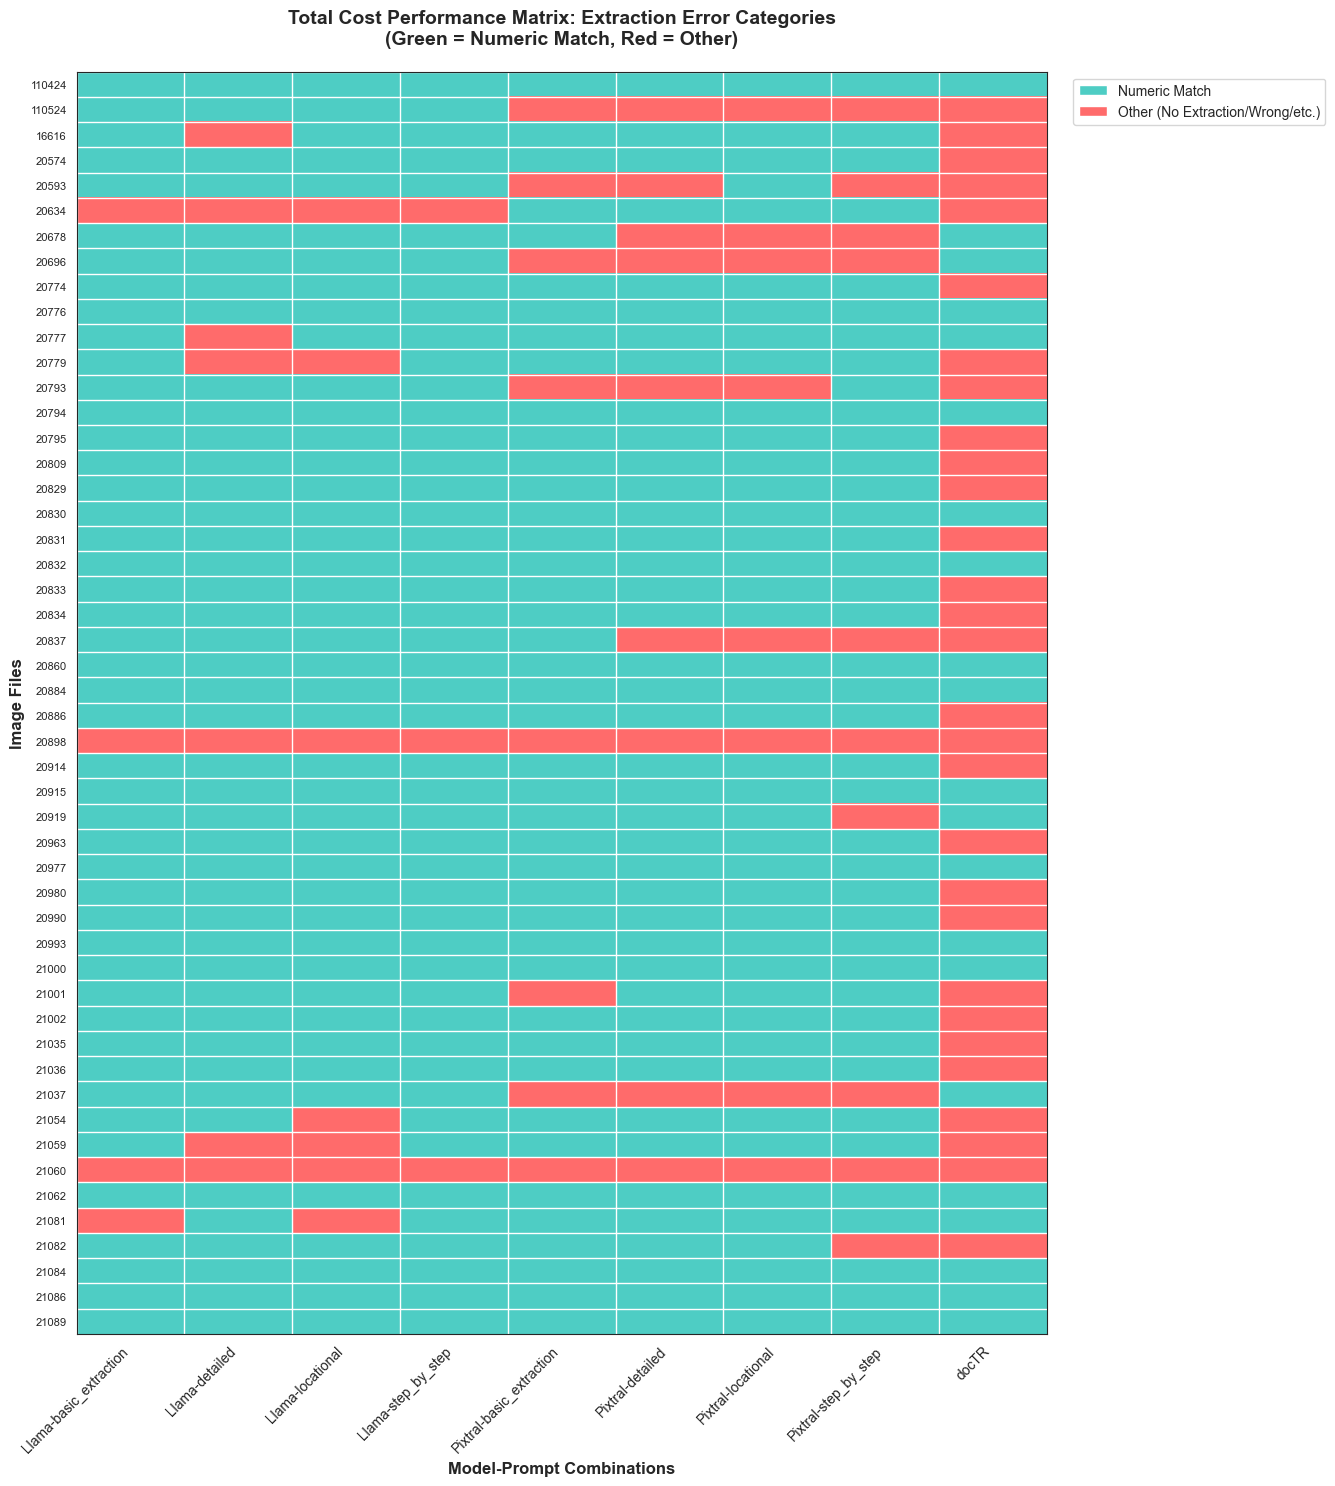

In [20]:
## Section 4.7: Total Cost Performance Matrix Analysis

import importlib
import src.visualization as viz
importlib.reload(viz)

# Generate total cost performance matrix analysis
fig, matrix_data = viz.generate_total_cost_performance_matrix_analysis(COMPREHENSIVE_DATASET)


Interesting.  There are a few images that can't be solved by any model-prompt combination.  Good to know what their characteristics are.  Some that work on one model but not the other.  Again interesting to explore.


### 7.2 Categories of Error (Typal Analysis)
Characterize the problems we are getting from the models to see what models fail in which ways.  Good feedback for future improvements.

🚀 GENERATING WORK ORDER ERROR CATEGORY MATRIX ANALYSIS
🔍 Creating work order error category count matrix data...
   • Found 9 model combinations
   • Found 6 error categories: Completely Wrong, Date Confusion, Exact Match, No Extraction, Partial Match, Unknown

📊 WORK ORDER ERROR CATEGORY MATRIX INSIGHTS

📈 Overall Statistics:
   • Total predictions: 750
   • Model combinations: 9
   • Error categories: 6

🔍 Error Category Distribution:
   • Exact Match: 401 (53.5%)
   • Partial Match: 298 (39.7%)
   • Completely Wrong: 33 (4.4%)
   • Date Confusion: 16 (2.1%)
   • No Extraction: 1 (0.1%)
   • Unknown: 1 (0.1%)

🏆 Model Performance Summary:
   • Llama-basic_extraction: 33/50 exact matches (66.0%)
   • Llama-detailed: 27/50 exact matches (54.0%)
   • Llama-locational: 35/50 exact matches (70.0%)
   • Llama-step_by_step: 37/50 exact matches (74.0%)
   • Pixtral-basic_extraction: 35/50 exact matches (70.0%)
   • Pixtral-detailed: 35/50 exact matches (70.0%)
   • Pixtral-locational: 35/50 

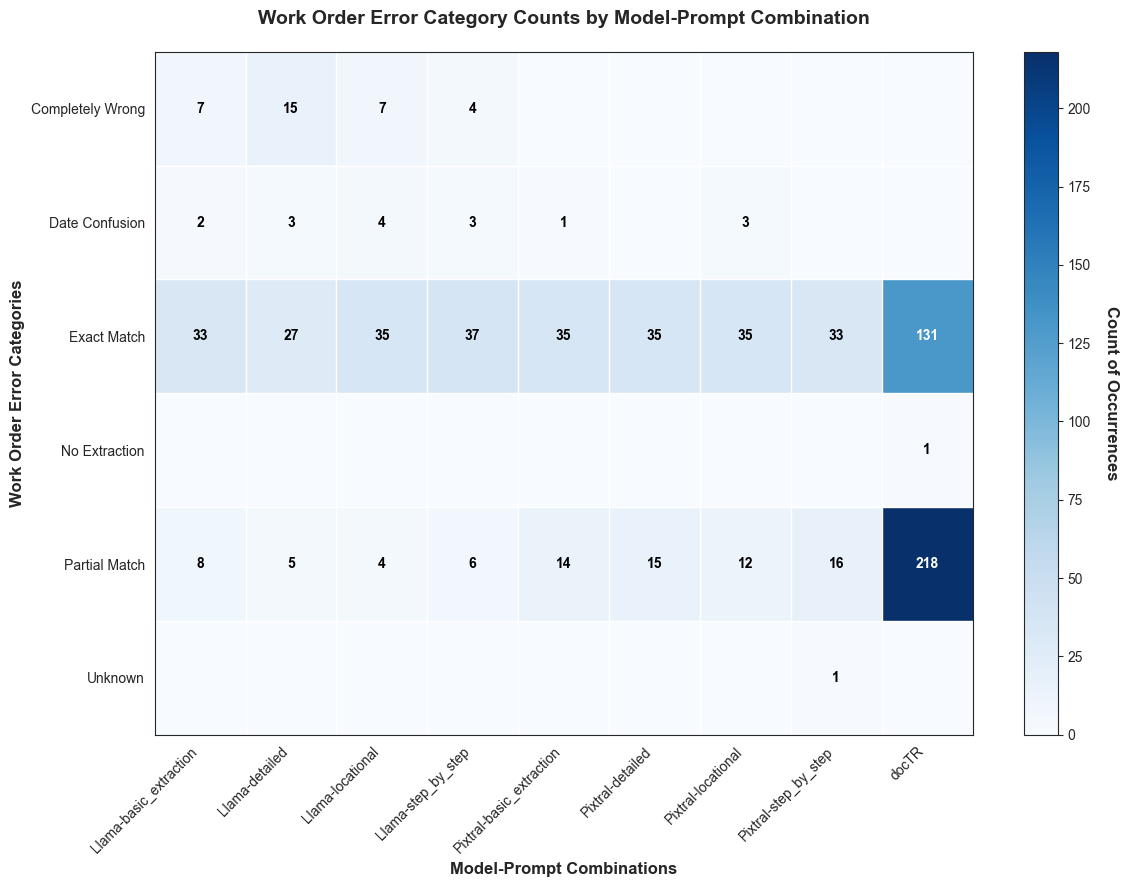

In [21]:
## Section 4.8: Work Order Error Category Count Matrix

import importlib
import src.visualization as viz
importlib.reload(viz)

# Generate work order error category matrix analysis
fig, matrix_data = viz.generate_work_order_error_category_matrix_analysis(COMPREHENSIVE_DATASET)


Llama step-by-step gets the most exactly right while pixtral-detailed gets the least totally wrong and limits their errors to partial matches.  Could be solved with training. 

🚀 GENERATING TOTAL COST ERROR CATEGORY MATRIX ANALYSIS
🔍 Creating total cost error category count matrix data...
   • Found 9 model combinations
   • Found 6 error categories: Completely Wrong, Extra Digit, Missing Digit, No Extraction, Numeric Match, Unknown

📊 TOTAL COST ERROR CATEGORY MATRIX INSIGHTS

📈 Overall Statistics:
   • Total predictions: 750
   • Model combinations: 9
   • Error categories: 6

🔍 Error Category Distribution:
   • Numeric Match: 517 (68.9%)
   • Completely Wrong: 123 (16.4%)
   • No Extraction: 68 (9.1%)
   • Extra Digit: 27 (3.6%)
   • Missing Digit: 14 (1.9%)
   • Unknown: 1 (0.1%)

🏆 Model Performance Summary:
   • Llama-basic_extraction: 46/50 numeric matches (92.0%)
   • Llama-detailed: 43/50 numeric matches (86.0%)
   • Llama-locational: 43/50 numeric matches (86.0%)
   • Llama-step_by_step: 47/50 numeric matches (94.0%)
   • Pixtral-basic_extraction: 42/50 numeric matches (84.0%)
   • Pixtral-detailed: 41/50 numeric matches (82.0%)
   • Pixtral-locatio

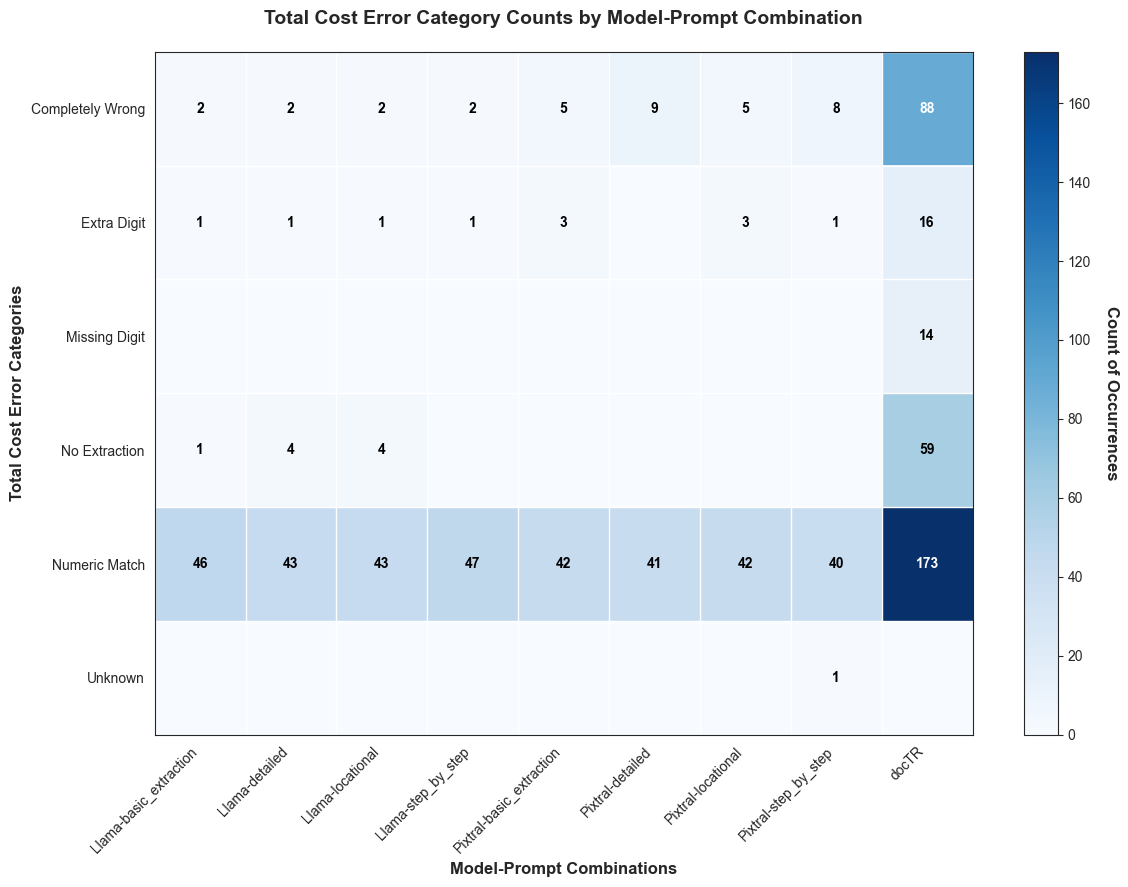

In [22]:
## Section 4.9: Total Cost Error Category Count Matrix

import importlib
import src.visualization as viz
importlib.reload(viz)

# Generate total cost error category matrix analysis
fig, matrix_data = viz.generate_total_cost_error_category_matrix_analysis(COMPREHENSIVE_DATASET)


Llama seems to be the clear winner on the total cost category with llama step-by-step the best of the best.

## 8. Conclusion and Way-Ahead
Doctr OCR can be fine-tuned but it would not be as efficient to try and train it up to standards.
Llama offers great numeric analysis especially when the field is clearly identifiable ($ sign or xxx.xx pattern) 
with better prompting,  fine tuning, and post processing it can made production grade
minaturize for local deployment
Pixtral is consistant and easier with the i/o.  With a medium amount of training it could be brought up to industry standards.  It's architecture is likely better suited for large scale deployment? 